# Imports

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import math
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

from numpy import array, linspace
from sklearn.neighbors import KernelDensity
from matplotlib.pyplot import plot
from scipy.signal import argrelextrema
import random

# pd.set_option('display.max_columns', None)
plt.rcParams["figure.figsize"] = (60, 40)
%matplotlib inline

In [2]:
yf.download('AAPL', start="2015-01-01")

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: OperationalError('no such table: _kv')


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


In [2]:
from handlers.DataHandler import DataHandler
from handlers.ClusterHandler import ClusterHandler

In [3]:
### GLOBAL VARIABLES ###
y_horizon = 13

# Load Data

In [4]:
# Get the data
train_X, train_y, test_X, test_y = DataHandler.getData("MS", "1998-01-01", "2015-12-31", "2016-01-01", "2023-01-01", y_horizon)

# Create and use the Cluster object
cls = ClusterHandler(train_X, train_y, test_X, test_y, eps=0.00001, mergeCluster=True, splitLargest=True)
clustered_train_X, clustered_train_y, clustered_test_X, clustered_test_y = cls.cluster()

# Access the clustering results
feature_cluster_stats = cls.feature_cluster_stats
y_cluster_stats = cls.y_cluster_stats

Open had 16 clusters
High had 15 clusters
Low had 14 clusters
Close had 19 clusters
Volume had 4 clusters
daily_log_return_0 had 8 clusters
daily_log_return_1 had 8 clusters
daily_log_return_2 had 8 clusters
daily_log_return_3 had 8 clusters
daily_log_return_4 had 8 clusters
daily_log_return_5 had 8 clusters
daily_log_return_6 had 8 clusters
daily_log_return_7 had 8 clusters
daily_log_return_8 had 8 clusters
daily_log_return_9 had 8 clusters
daily_log_return_10 had 8 clusters
daily_log_return_11 had 8 clusters
daily_log_return_12 had 8 clusters
intraday_log_return_0 had 9 clusters
intraday_log_return_1 had 9 clusters
intraday_log_return_2 had 9 clusters
intraday_log_return_3 had 9 clusters
intraday_log_return_4 had 9 clusters
intraday_log_return_5 had 9 clusters
intraday_log_return_6 had 9 clusters
intraday_log_return_7 had 9 clusters
intraday_log_return_8 had 9 clusters
intraday_log_return_9 had 9 clusters
intraday_log_return_10 had 9 clusters
intraday_log_return_11 had 9 clusters
int

/home/FYP/chia0427/fyp/handlers/ClusterHandler.py:180: RuntimeWarning: divide by zero encountered in scalar divide
  return math.exp(-((x - sampleMean)**2 / (2 * (sampleDevi**2))))
/home/FYP/chia0427/fyp/handlers/ClusterHandler.py:180: RuntimeWarning: invalid value encountered in scalar divide
  return math.exp(-((x - sampleMean)**2 / (2 * (sampleDevi**2))))
/home/FYP/chia0427/fyp/handlers/ClusterHandler.py:180: RuntimeWarning: divide by zero encountered in scalar divide
  return math.exp(-((x - sampleMean)**2 / (2 * (sampleDevi**2))))
/home/FYP/chia0427/fyp/handlers/ClusterHandler.py:180: RuntimeWarning: invalid value encountered in scalar divide
  return math.exp(-((x - sampleMean)**2 / (2 * (sampleDevi**2))))
/home/FYP/chia0427/fyp/handlers/ClusterHandler.py:180: RuntimeWarning: divide by zero encountered in scalar divide
  return math.exp(-((x - sampleMean)**2 / (2 * (sampleDevi**2))))
/home/FYP/chia0427/fyp/handlers/ClusterHandler.py:180: RuntimeWarning: invalid value encountered 

1m_mom had 9 clusters
3m_mom had 15 clusters
6m_mom had 15 clusters
12m_mom had 16 clusters
18m_mom had 16 clusters
mom_change_1m_3m had 11 clusters
mom_change_3m_6m had 16 clusters
mom_change_6m_12m had 15 clusters
y_log_return_0 had 8 clusters
y_log_return_1 had 4 clusters
y_log_return_2 had 10 clusters
y_log_return_3 had 8 clusters
y_log_return_4 had 5 clusters
y_log_return_5 had 9 clusters
y_log_return_6 had 8 clusters
y_log_return_7 had 8 clusters
y_log_return_8 had 11 clusters
y_log_return_9 had 9 clusters
y_log_return_10 had 10 clusters
y_log_return_11 had 13 clusters
y_log_return_12 had 10 clusters


In [5]:
clustered_train_X.drop(columns=clustered_train_X.columns[clustered_train_X.isna().any(axis=0)], inplace=True)
clustered_test_X.drop(columns=clustered_test_X.columns[clustered_test_X.isna().any(axis=0)], inplace=True)

In [6]:
clustered_train_X.isna().any().any()

np.False_

In [7]:
clustered_test_X.isna().any()

PDF_Open_0                  False
PDF_Open_1                  False
PDF_Open_2                  False
PDF_Open_3                  False
PDF_Open_4                  False
                            ...  
PDF_mom_change_6m_12m_10    False
PDF_mom_change_6m_12m_11    False
PDF_mom_change_6m_12m_12    False
PDF_mom_change_6m_12m_13    False
PDF_mom_change_6m_12m_14    False
Length: 579, dtype: bool

In [8]:
(clustered_test_X.columns == clustered_train_X.columns).all()

np.True_

# Functions and model definition

In [9]:
import torch
import torch.nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import math
from sklearn.metrics import r2_score
from torch.nn import TransformerEncoder, TransformerEncoderLayer

In [10]:
# class TransformerModel(torch.nn.Module):
#     def __init__(self, input_dim, output_dim, num_heads=10, ff_dim=32, num_transformer_blocks=4, mlp_units=256, dropout=0.25, noHiddenLayers = 1, sigmoidOrSoftmax = 0):
#         super(TransformerModel, self).__init__()

#         # Encoder layer
#         encoder_layers = TransformerEncoderLayer(d_model=input_dim, nhead=num_heads, dim_feedforward=mlp_units)
#         self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers=num_transformer_blocks)
        
#         fcList = [torch.nn.Linear(input_dim, mlp_units), torch.nn.ReLU()]
#         for i in range(noHiddenLayers):
#             fcList.append(torch.nn.Linear(mlp_units, mlp_units//2))
#             fcList.append(torch.nn.ReLU())
#             mlp_units = mlp_units//2
#         fcList.append(torch.nn.Linear(mlp_units, output_dim))
#         if sigmoidOrSoftmax == 0:
#             fcList.append(torch.nn.Sigmoid())
#         else:
#             fcList.append(torch.nn.Softmax())
        
#         self.fc = torch.nn.Sequential(*fcList)

#     def forward(self, src):
#         # src shape: (seq_length, batch_size, input_dim)
        
#         # Pass input through the transformer encoder
#         encoder_output = self.transformer_encoder(src)
#         encoder_output = encoder_output[:,:]
#         output = self.fc(encoder_output)
#         return output   

class TransformerModel(torch.nn.Module):
    def __init__(self, input_dim, output_dim, num_heads=10, ff_dim=32, num_transformer_blocks=4, mlp_units=256, dropout=0.25, noHiddenLayers=1, sigmoidOrSoftmax=0):
        super(TransformerModel, self).__init__()

        # print(f"Initializing TransformerModel with input_dim: {input_dim}, output_dim: {output_dim}")

        # # Ensure input_dim is divisible by num_heads
        # if input_dim % num_heads != 0:
        #     new_input_dim = (input_dim // num_heads + 1) * num_heads
        #     print(f"Adjusting input_dim from {input_dim} to {new_input_dim} to be divisible by num_heads ({num_heads})")
        #     input_dim = new_input_dim

        # Encoder layer with ff_dim and dropout
        encoder_layers = TransformerEncoderLayer(
            d_model=input_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            activation='relu',
            batch_first=True
        )
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers=num_transformer_blocks)
        
        # Dropout layer
        self.dropout = torch.nn.Dropout(dropout)
        
        # MLP layers
        fcList = [torch.nn.Linear(input_dim, mlp_units), torch.nn.ReLU(), self.dropout]
        for i in range(noHiddenLayers):
            fcList.extend([
                torch.nn.Linear(mlp_units, mlp_units//2),
                torch.nn.ReLU(),
                self.dropout
            ])
            mlp_units = mlp_units//2
        fcList.append(torch.nn.Linear(mlp_units, output_dim))
        
        # Output activation
        if sigmoidOrSoftmax == 0:
            fcList.append(torch.nn.Sigmoid())
        else:
            fcList.append(torch.nn.Softmax(dim=-1))
        
        self.fc = torch.nn.Sequential(*fcList)

    def forward(self, src):
        # src shape: (batch_size, seq_length, input_dim)
        
        # Pass input through the transformer encoder
        encoder_output = self.transformer_encoder(src)
        
        # Apply dropout after the transformer encoder
        encoder_output = self.dropout(encoder_output)
        
        # Pass through the MLP layers
        output = self.fc(encoder_output)
        return output
    
def increaseInstancesExtreme(train, thresholdToIncrease=0.03):
    extraData = train[(train[f"Close_t+{yTarget}"]>thresholdToIncrease) | (train[f"Close_t+{yTarget}"]<-thresholdToIncrease)]
    return pd.concat([train, extraData] ,axis = 0)

def weightAvg(pred, noClusters, deltaOnly = True):
    center = [i[0] for i in cls.yClsDic.values()]
    std = [i[1] for i in cls.yClsDic.values()]
    std = np.tile(center,(pred.shape[0],1))
    centers = np.tile(center, (pred.shape[0], 1))
    pred = np.nan_to_num(pred, nan=0, posinf=0, neginf=0)
    denominator = pred
    denominator = denominator.sum(axis=1, keepdims=True)
    numerator = (pred * centers)
    numerator = numerator.sum(axis = 1, keepdims = True)
    result = numerator / denominator
    result = np.squeeze(result)
    if not deltaOnly:
        return (result * cls.test.Close.to_numpy())+cls.test.Close.to_numpy()
    else:
        return (result * cls.test.Close.to_numpy())
    
def padData(X, X_test, padDim):
    zeros_array = np.zeros((X.shape[0], padDim))
    zeros_array_test = np.zeros((X_test.shape[0], padDim))

    X = np.concatenate((X, zeros_array), axis=1)
    X_test = np.concatenate((X_test, zeros_array_test), axis=1)
    return X, X_test

def testData(pred, Y_test):
    res = (pred-Y_test)**2
    res[np.isnan(res)]=0
    mse = np.mean(res)
    return mse  

# Genetic Algorithm

In [16]:
def hyperparameters():
    parameters = {
        'num_heads': [1, 2, 3, 4],
        'feed_forward_dim': [32, 64, 128],
        'num_transformer_blocks': [1, 2, 3],
        'mlp_units': [64, 128, 256, 512],
        'dropout_rate': [0, 0.05, 0.1, 0.2],
        'learning_rate': [0.001, 0.0001, 0.00001, 0.000005],
        'num_mlp_layers': [3, 5, 8],
        'num_epochs': [50, 100, 200, 500],
        'activation_function': [0, 1]  # 0 for sigmoid, 1 for softmax
    }
    return parameters

def generate_population(size):
    parameters = hyperparameters()
    population = []
    
    while len(population) < size:
        chromosome = {key: random.choice(value) for key, value in parameters.items()}
        if chromosome not in population:
            population.append(chromosome)
    return population

def crossover(parent1, parent2):
    child = {}
    for key in parent1.keys():
        child[key] = random.choice([parent1[key], parent2[key]])
    return child

def mutation(chromosome, mutation_rate=0.1):
    parameters = hyperparameters()
    for key in chromosome.keys():
        if random.random() < mutation_rate:
            chromosome[key] = random.choice(parameters[key])
    return chromosome

def fitness(chromosome, X, y, t_X, t_y, crisp_t_y):
    model, r2, pred = train_ga_model(
        X, y, t_X, t_y, crisp_t_y,
        num_heads=chromosome['num_heads'],
        feed_forward_dim=chromosome['feed_forward_dim'],
        num_transformer_blocks=chromosome['num_transformer_blocks'],
        mlp_units=chromosome['mlp_units'],
        dropout_rate=chromosome['dropout_rate'],
        learning_rate=chromosome['learning_rate'],
        num_mlp_layers=chromosome['num_mlp_layers'],
        num_epochs=chromosome['num_epochs'],
        activation_function=chromosome['activation_function']
    )
    return r2

def genetic_algorithm(X, y, t_X, t_y, crisp_t_y, population_size=20, generations=10, elite_size=2):
    population = generate_population(population_size)
    
    for generation in range(generations):
        print(f"Generation {generation + 1}/{generations}")
        
        # Evaluate fitness
        fitness_scores = [(chromosome, fitness(chromosome, X, y, t_X, t_y, crisp_t_y)) for chromosome in population]
        fitness_scores.sort(key=lambda x: x[1], reverse=True)
        
        # Select elite
        new_population = [chromosome for chromosome, _ in fitness_scores[:elite_size]]
        
        # Generate offspring
        while len(new_population) < population_size:
            parent1, parent2 = random.sample(population, 2)
            child = crossover(parent1, parent2)
            child = mutation(child)
            new_population.append(child)
        
        population = new_population
        
        best_chromosome, best_fitness = fitness_scores[0]
        print(f"Best fitness: {best_fitness}")
        print(f"Best chromosome: {best_chromosome}")
    
    return fitness_scores[0]

# GA Train

In [17]:
train_val_split = 0.7
pred_col = test_y.columns[0]

train_rows = int(len(clustered_train_X) * train_val_split)

X = clustered_train_X.iloc[:train_rows].to_numpy()
val_X = clustered_train_X.iloc[train_rows:].to_numpy()

y = clustered_train_y[[c for c in clustered_train_y.columns if pred_col in c]].iloc[:train_rows].to_numpy()
val_y = clustered_train_y[[c for c in clustered_train_y.columns if pred_col in c]].iloc[train_rows:].to_numpy()
crisp_val_y = train_y[pred_col].iloc[train_rows:].to_numpy()

In [18]:
best_chromosome, best_fitness = genetic_algorithm(X, y, val_X, val_y, crisp_val_y)
print("Best hyperparameters:", best_chromosome)
print("Best R2 score:", best_fitness)

# Train final model with best hyperparameters
# final_model, final_r2, final_pred = train_ga_model(
#     X, y, t_X, t_y, crisp_t_y,
#     **best_chromosome
# )
# print("Final model R2 score:", final_r2)

Generation 1/10
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/200] | Loss: 0.0688 | R² Score: -4.9955 | Log Return R² Score: -3.6269
Epoch [51/200] | Loss: 0.0448 | R² Score: -0.3931 | Log Return R² Score: -0.4917
Epoch [101/200] | Loss: 0.0343 | R² Score: -0.2377 | Log Return R² Score: -0.5186
Epoch [151/200] | Loss: 0.0240 | R² Score: -0.0346 | Log Return R² Score: -1.3299
Test R2 Score: -1.5621539794630488
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.1710 | R² Score: -51.4631 | Log Return R² Score: -2.9906
Test R2 Score: -1.4460175022057777
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/100] | Loss: 0.0687 | R² Score: -4.0479 | Log Return R² Score: -3.2928
Epoch [51/100] | Loss: 0.0265 | R² Score: -0.3608 | Log Return R² Score: -0.3899
Test R2 Score: -0.9108837874633462
Training on cuda
Epoch [1/200] | Loss: 0.1921 | R² Score: -56.1857 | Log Return R² Score: -3.2078
Epoch [51/200] | Loss: 0.0452 | R² Score: -0.4834 | Log Return R² Score: -0.3989
Epoch [101/200] | Loss: 0.0192 | R² Score: -0.0235 | Log Return R² Score: -1.1798
Epoch [151/200] | Loss: 0.0120 | R² Score: 0.2372 | Log Return R² Score: -0.9886
Test R2 Score: -1.4224130272281377
Training on cuda
Epoch [1/200] | Loss: 0.1921 | R² Score: -59.0155 | Log Return R² Score: -3.4776
Epoch [51/200] | Loss: 0.0429 | R² Score: -0.8884 | Log Return R² Score: -0.2560
Epoch [101/200] | Loss: 0.0136 | R² Score: 0.0663 | Log Return R² Score: -2.7614
Epoch [151/200] | Loss: 0.0063 | R² Score: 0.3566 | Log Return R² Score: -8.0346
Test R2 Score: -9.800827721239726
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/200] | Loss: 0.0770 | R² Score: -11.4166 | Log Return R² Score: -0.9777
Epoch [51/200] | Loss: 0.0454 | R² Score: -0.0345 | Log Return R² Score: -2.7597
Epoch [101/200] | Loss: 0.0451 | R² Score: -0.0185 | Log Return R² Score: -2.7881
Epoch [151/200] | Loss: 0.0451 | R² Score: -0.0102 | Log Return R² Score: -2.4677
Test R2 Score: -2.643723398013149
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.0490 | R² Score: -0.3012 | Log Return R² Score: -2.4021
Test R2 Score: -2.6709763657141465
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/500] | Loss: 0.1756 | R² Score: -53.5299 | Log Return R² Score: -3.7368
Epoch [51/500] | Loss: 0.0361 | R² Score: -0.5008 | Log Return R² Score: -0.3983
Epoch [101/500] | Loss: 0.0052 | R² Score: 0.4579 | Log Return R² Score: -2.8181
Epoch [151/500] | Loss: 0.0029 | R² Score: 0.5616 | Log Return R² Score: -3.6344
Epoch [201/500] | Loss: 0.0022 | R² Score: 0.5866 | Log Return R² Score: -3.6162
Epoch [251/500] | Loss: 0.0019 | R² Score: 0.5963 | Log Return R² Score: -3.5346
Epoch [301/500] | Loss: 0.0017 | R² Score: 0.6017 | Log Return R² Score: -3.3558
Epoch [351/500] | Loss: 0.0016 | R² Score: 0.6053 | Log Return R² Score: -3.4242
Epoch [401/500] | Loss: 0.0015 | R² Score: 0.6076 | Log Return R² Score: -3.6330
Epoch [451/500] | Loss: 0.0014 | R² Score: 0.6104 | Log Return R² Score: -3.5091
Test R2 Score: -3.652402898866362
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/500] | Loss: 0.0504 | R² Score: -0.5713 | Log Return R² Score: -2.4292
Epoch [51/500] | Loss: 0.0452 | R² Score: -0.0108 | Log Return R² Score: -2.6311
Epoch [101/500] | Loss: 0.0451 | R² Score: -0.0115 | Log Return R² Score: -2.6438
Epoch [151/500] | Loss: 0.0451 | R² Score: -0.0108 | Log Return R² Score: -2.5935
Epoch [201/500] | Loss: 0.0452 | R² Score: -0.0105 | Log Return R² Score: -2.6683
Epoch [251/500] | Loss: 0.0451 | R² Score: -0.0110 | Log Return R² Score: -2.6719
Epoch [301/500] | Loss: 0.0452 | R² Score: -0.0098 | Log Return R² Score: -2.6250
Epoch [351/500] | Loss: 0.0450 | R² Score: -0.0099 | Log Return R² Score: -2.6703
Epoch [401/500] | Loss: 0.0450 | R² Score: -0.0104 | Log Return R² Score: -2.6424
Epoch [451/500] | Loss: 0.0451 | R² Score: -0.0109 | Log Return R² Score: -2.5741
Test R2 Score: -2.667273212683177
Training on cuda
Epoch [1/500] | Loss: 0.1918 | R² Score: -58.0234 | Log Return R² Score: -3.5674
Epoch [51/500] | Loss: 0.0593 | R² Score: -5.6406 |

/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/100] | Loss: 0.0544 | R² Score: -1.6243 | Log Return R² Score: -0.8581
Epoch [51/100] | Loss: 0.0051 | R² Score: 0.6553 | Log Return R² Score: -1.9040
Test R2 Score: -1.2909821162793649
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.0657 | R² Score: -3.5726 | Log Return R² Score: -2.5835
Test R2 Score: -0.4181973477062777
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/200] | Loss: 0.1810 | R² Score: -50.0538 | Log Return R² Score: -2.1879
Epoch [51/200] | Loss: 0.0106 | R² Score: 0.1138 | Log Return R² Score: -1.6910
Epoch [101/200] | Loss: 0.0054 | R² Score: 0.4111 | Log Return R² Score: -1.3866
Epoch [151/200] | Loss: 0.0042 | R² Score: 0.4973 | Log Return R² Score: -1.7547
Test R2 Score: -1.8514185489746695
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/500] | Loss: 0.0650 | R² Score: -3.5737 | Log Return R² Score: -1.9911
Epoch [51/500] | Loss: 0.0178 | R² Score: 0.2210 | Log Return R² Score: -1.7802
Epoch [101/500] | Loss: 0.0082 | R² Score: 0.4446 | Log Return R² Score: -2.9846
Epoch [151/500] | Loss: 0.0064 | R² Score: 0.4924 | Log Return R² Score: -2.4066
Epoch [201/500] | Loss: 0.0055 | R² Score: 0.5225 | Log Return R² Score: -2.1374
Epoch [251/500] | Loss: 0.0050 | R² Score: 0.5590 | Log Return R² Score: -2.0589
Epoch [301/500] | Loss: 0.0044 | R² Score: 0.6026 | Log Return R² Score: -1.9921
Epoch [351/500] | Loss: 0.0041 | R² Score: 0.6497 | Log Return R² Score: -1.9890
Epoch [401/500] | Loss: 0.0038 | R² Score: 0.7028 | Log Return R² Score: -2.0331
Epoch [451/500] | Loss: 0.0037 | R² Score: 0.7252 | Log Return R² Score: -1.9094
Test R2 Score: -1.9749106226578368
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/200] | Loss: 0.0751 | R² Score: -10.5362 | Log Return R² Score: -0.8271
Epoch [51/200] | Loss: 0.0451 | R² Score: -0.0119 | Log Return R² Score: -2.5940
Epoch [101/200] | Loss: 0.0450 | R² Score: -0.0104 | Log Return R² Score: -2.6094
Epoch [151/200] | Loss: 0.0450 | R² Score: -0.0083 | Log Return R² Score: -2.6919
Test R2 Score: -2.7158290874350954
Training on cuda
Epoch [1/100] | Loss: 0.0646 | R² Score: -3.4003 | Log Return R² Score: -1.6854
Epoch [51/100] | Loss: 0.0387 | R² Score: -0.2767 | Log Return R² Score: -0.4700
Test R2 Score: -0.10055605234723997
Training on cuda
Epoch [1/100] | Loss: 0.1790 | R² Score: -53.2813 | Log Return R² Score: -3.8312
Epoch [51/100] | Loss: 0.0229 | R² Score: -0.2666 | Log Return R² Score: -1.1103
Test R2 Score: -4.245142102992188
Training on cuda
Epoch [1/100] | Loss: 0.0491 | R² Score: -0.5249 | Log Return R² Score: -1.5161
Epoch [51/100] | Loss: 0.0454 | R² Score: -0.0122 | Log Return R² Score: -2.7983
Test R2 Score: -2.8150685615243196

/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.0650 | R² Score: -3.5857 | Log Return R² Score: -2.5993
Test R2 Score: -0.2733135193934182
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/100] | Loss: 0.1900 | R² Score: -51.2683 | Log Return R² Score: -3.1044
Epoch [51/100] | Loss: 0.0577 | R² Score: -2.0574 | Log Return R² Score: -0.2255
Test R2 Score: -0.7576843939438187
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.0473 | R² Score: -0.2490 | Log Return R² Score: -2.5972
Test R2 Score: -2.832581725962737
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/200] | Loss: 0.0614 | R² Score: -5.2857 | Log Return R² Score: -1.4867
Epoch [51/200] | Loss: 0.0450 | R² Score: -0.0080 | Log Return R² Score: -2.5050
Epoch [101/200] | Loss: 0.0450 | R² Score: -0.0087 | Log Return R² Score: -2.5725
Epoch [151/200] | Loss: 0.0449 | R² Score: -0.0052 | Log Return R² Score: -2.4534
Test R2 Score: -2.4092628202159023
Training on cuda
Epoch [1/200] | Loss: 0.1970 | R² Score: -60.8396 | Log Return R² Score: -3.3331
Epoch [51/200] | Loss: 0.0441 | R² Score: -0.6866 | Log Return R² Score: -0.2325
Epoch [101/200] | Loss: 0.0345 | R² Score: -0.1452 | Log Return R² Score: -0.5940
Epoch [151/200] | Loss: 0.0182 | R² Score: 0.1380 | Log Return R² Score: -0.8756
Test R2 Score: -1.1120947527529208
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/100] | Loss: 0.0663 | R² Score: -3.4487 | Log Return R² Score: -1.9161
Epoch [51/100] | Loss: 0.0259 | R² Score: -0.0972 | Log Return R² Score: -0.2370
Test R2 Score: -1.1021166846821435
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/100] | Loss: 0.1548 | R² Score: -25.6371 | Log Return R² Score: -1.4029
Epoch [51/100] | Loss: 0.0033 | R² Score: 0.6013 | Log Return R² Score: -0.8551
Test R2 Score: -1.8878394955915447
Training on cuda
Epoch [1/200] | Loss: 0.0488 | R² Score: -0.4535 | Log Return R² Score: -1.3341
Epoch [51/200] | Loss: 0.0452 | R² Score: -0.0115 | Log Return R² Score: -2.7043
Epoch [101/200] | Loss: 0.0452 | R² Score: -0.0121 | Log Return R² Score: -2.7053
Epoch [151/200] | Loss: 0.0452 | R² Score: -0.0124 | Log Return R² Score: -2.7708
Test R2 Score: -2.675594910608279
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/200] | Loss: 0.0640 | R² Score: -3.5574 | Log Return R² Score: -2.7287
Epoch [51/200] | Loss: 0.0439 | R² Score: -0.1263 | Log Return R² Score: -0.8508
Epoch [101/200] | Loss: 0.0342 | R² Score: -0.0184 | Log Return R² Score: -2.0641
Epoch [151/200] | Loss: 0.0268 | R² Score: 0.0784 | Log Return R² Score: -2.3064
Test R2 Score: -2.1860842692659403
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.1909 | R² Score: -58.0403 | Log Return R² Score: -3.4842
Test R2 Score: -0.11850951426165701
Training on cuda
Epoch [1/100] | Loss: 0.1106 | R² Score: -20.3496 | Log Return R² Score: -0.0095
Epoch [51/100] | Loss: 0.0027 | R² Score: 0.5621 | Log Return R² Score: -0.9680
Test R2 Score: -2.3825580064638134
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/200] | Loss: 0.2048 | R² Score: -61.4039 | Log Return R² Score: -3.1599
Epoch [51/200] | Loss: 0.0673 | R² Score: -5.3554 | Log Return R² Score: -0.0821
Epoch [101/200] | Loss: 0.0402 | R² Score: -3.2649 | Log Return R² Score: -1.0148
Epoch [151/200] | Loss: 0.0220 | R² Score: -1.1085 | Log Return R² Score: -1.2450
Test R2 Score: -1.4159263146947145
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.0654 | R² Score: -3.2040 | Log Return R² Score: -2.6599
Test R2 Score: -2.762135198525885
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/100] | Loss: 0.0587 | R² Score: -2.8796 | Log Return R² Score: -0.0213
Epoch [51/100] | Loss: 0.0067 | R² Score: 0.4776 | Log Return R² Score: -0.3531
Test R2 Score: -0.9501846394752289
Training on cuda
Epoch [1/100] | Loss: 0.0680 | R² Score: -3.9947 | Log Return R² Score: -3.6340
Epoch [51/100] | Loss: 0.0383 | R² Score: -0.0699 | Log Return R² Score: -0.8218
Test R2 Score: -0.826330501906849
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/100] | Loss: 0.0522 | R² Score: -0.7121 | Log Return R² Score: -1.0002
Epoch [51/100] | Loss: 0.0453 | R² Score: -0.0158 | Log Return R² Score: -2.7838
Test R2 Score: -2.7491449719287866
Training on cuda
Epoch [1/50] | Loss: 0.0490 | R² Score: -0.3173 | Log Return R² Score: -2.1904
Test R2 Score: -2.4936483507420495
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/500] | Loss: 0.1400 | R² Score: -29.7050 | Log Return R² Score: -2.7872
Epoch [51/500] | Loss: 0.0047 | R² Score: 0.4048 | Log Return R² Score: -1.9255
Epoch [101/500] | Loss: 0.0027 | R² Score: 0.5395 | Log Return R² Score: -3.9385
Epoch [151/500] | Loss: 0.0022 | R² Score: 0.5742 | Log Return R² Score: -4.3825
Epoch [201/500] | Loss: 0.0019 | R² Score: 0.5874 | Log Return R² Score: -5.7644
Epoch [251/500] | Loss: 0.0014 | R² Score: 0.6914 | Log Return R² Score: -5.0521
Epoch [301/500] | Loss: 0.0012 | R² Score: 0.7113 | Log Return R² Score: -5.6740
Epoch [351/500] | Loss: 0.0011 | R² Score: 0.7121 | Log Return R² Score: -6.2204
Epoch [401/500] | Loss: 0.0010 | R² Score: 0.7206 | Log Return R² Score: -6.7794
Epoch [451/500] | Loss: 0.0009 | R² Score: 0.7316 | Log Return R² Score: -12.0202
Test R2 Score: -9.259246425003575
Training on cuda
Epoch [1/500] | Loss: 0.1767 | R² Score: -54.4260 | Log Return R² Score: -3.3894
Epoch [51/500] | Loss: 0.0384 | R² Score: -0.2750 | Log Re

/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.1908 | R² Score: -62.7398 | Log Return R² Score: -4.4400
Test R2 Score: -0.4950081587077393
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.0665 | R² Score: -4.0598 | Log Return R² Score: -3.5646
Test R2 Score: -0.9470571069731444
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/100] | Loss: 0.0649 | R² Score: -3.0367 | Log Return R² Score: -1.4508
Epoch [51/100] | Loss: 0.0178 | R² Score: 0.1664 | Log Return R² Score: -0.2667
Test R2 Score: -1.2437118888907093
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.1838 | R² Score: -59.2876 | Log Return R² Score: -3.7615
Test R2 Score: -0.005248168225289174
Training on cuda
Epoch [1/500] | Loss: 0.1214 | R² Score: -32.0506 | Log Return R² Score: -1.0125
Epoch [51/500] | Loss: 0.0024 | R² Score: 0.6722 | Log Return R² Score: -2.1330
Epoch [101/500] | Loss: 0.0011 | R² Score: 0.8830 | Log Return R² Score: -1.6824
Epoch [151/500] | Loss: 0.0007 | R² Score: 0.9712 | Log Return R² Score: -2.0296
Epoch [201/500] | Loss: 0.0005 | R² Score: 0.9759 | Log Return R² Score: -2.1431
Epoch [251/500] | Loss: 0.0004 | R² Score: 0.9851 | Log Return R² Score: -2.0662
Epoch [301/500] | Loss: 0.0003 | R² Score: 0.9856 | Log Return R² Score: -1.9133
Epoch [351/500] | Loss: 0.0003 | R² Score: 0.9884 | Log Return R² Score: -2.0326
Epoch [401/500] | Loss: 0.0002 | R² Score: 0.9887 | Log Return R² Score: -2.0907
Epoch [451/500] | Loss: 0.0002 | R² Score: 0.9928 | Log Return R² Score: -2.1734
Test R2 Score: -2.0216899824899106
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/100] | Loss: 0.1802 | R² Score: -47.2849 | Log Return R² Score: -2.5777
Epoch [51/100] | Loss: 0.0609 | R² Score: -2.4879 | Log Return R² Score: -0.2610
Test R2 Score: -0.7532018071133131
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.1486 | R² Score: -31.2973 | Log Return R² Score: -1.7049
Test R2 Score: -1.2383900191285786
Training on cuda
Epoch [1/200] | Loss: 0.0683 | R² Score: -7.7360 | Log Return R² Score: -1.5128
Epoch [51/200] | Loss: 0.0451 | R² Score: -0.0134 | Log Return R² Score: -2.6055
Epoch [101/200] | Loss: 0.0451 | R² Score: -0.0076 | Log Return R² Score: -2.5380
Epoch [151/200] | Loss: 0.0450 | R² Score: -0.0085 | Log Return R² Score: -2.4771
Test R2 Score: -2.6477470188581504
Training on cuda
Epoch [1/100] | Loss: 0.0639 | R² Score: -3.3148 | Log Return R² Score: -2.5793
Epoch [51/100] | Loss: 0.0227 | R² Score: 0.0802 | Log Return R² Score: -2.3483
Test R2 Score: -3.0151147563523377
Training on cuda
Epoch [1/50] | Loss: 0.0463 | R² Score: -0.3257 | Log Return R² Score: -2.8335
Test R2 Score: -1.1043780757462627
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.0489 | R² Score: -0.5053 | Log Return R² Score: -1.6936
Test R2 Score: -2.711836828867122
Training on cuda
Epoch [1/100] | Loss: 0.0656 | R² Score: -4.1088 | Log Return R² Score: -3.0665
Epoch [51/100] | Loss: 0.0196 | R² Score: 0.0618 | Log Return R² Score: 0.0196
Test R2 Score: -0.5355834303896461
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/100] | Loss: 0.1783 | R² Score: -51.6029 | Log Return R² Score: -2.4251
Epoch [51/100] | Loss: 0.0414 | R² Score: -0.5664 | Log Return R² Score: -0.3253
Test R2 Score: -3.3168286556350415
Training on cuda
Epoch [1/50] | Loss: 0.0648 | R² Score: -3.4271 | Log Return R² Score: -2.2426
Test R2 Score: -2.0241093051132397
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/200] | Loss: 0.0621 | R² Score: -5.3963 | Log Return R² Score: -2.3333
Epoch [51/200] | Loss: 0.0453 | R² Score: -0.0103 | Log Return R² Score: -2.4567
Epoch [101/200] | Loss: 0.0450 | R² Score: -0.0059 | Log Return R² Score: -2.5933
Epoch [151/200] | Loss: 0.0449 | R² Score: -0.0034 | Log Return R² Score: -2.6092
Test R2 Score: -2.5062956012740694
Training on cuda
Epoch [1/100] | Loss: 0.0647 | R² Score: -3.1500 | Log Return R² Score: -1.7388
Epoch [51/100] | Loss: 0.0257 | R² Score: -0.4905 | Log Return R² Score: -0.4087
Test R2 Score: -1.2367965810953896
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.0672 | R² Score: -4.4443 | Log Return R² Score: -3.2019
Test R2 Score: -1.3833241188559318
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.0661 | R² Score: -3.3099 | Log Return R² Score: -2.7322
Test R2 Score: -0.8210830199093717
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/100] | Loss: 0.0671 | R² Score: -4.3039 | Log Return R² Score: -3.2560
Epoch [51/100] | Loss: 0.0403 | R² Score: -0.0929 | Log Return R² Score: -0.8532
Test R2 Score: -2.003375234614757
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/100] | Loss: 0.0735 | R² Score: -7.8062 | Log Return R² Score: -1.1469
Epoch [51/100] | Loss: 0.0452 | R² Score: -0.0090 | Log Return R² Score: -2.3386
Test R2 Score: -2.2796779392804347
Best fitness: -0.005248168225289174
Best chromosome: {'num_heads': 3, 'feed_forward_dim': 32, 'num_transformer_blocks': 2, 'mlp_units': 64, 'dropout_rate': 0.1, 'learning_rate': 5e-06, 'num_mlp_layers': 3, 'num_epochs': 50, 'activation_function': 0}
Generation 4/10
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.1997 | R² Score: -57.4956 | Log Return R² Score: -3.1937
Test R2 Score: -0.3554077258089303
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.1957 | R² Score: -62.2026 | Log Return R² Score: -3.9457
Test R2 Score: -1.0538766037395448
Training on cuda
Epoch [1/100] | Loss: 0.0649 | R² Score: -3.6653 | Log Return R² Score: -2.0318
Epoch [51/100] | Loss: 0.0163 | R² Score: 0.1326 | Log Return R² Score: -1.2659
Test R2 Score: -1.022348924818436
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.0498 | R² Score: -0.9084 | Log Return R² Score: -1.2401
Test R2 Score: -1.5692280099179978
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.0649 | R² Score: -3.2016 | Log Return R² Score: -2.4556
Test R2 Score: -0.3539955664747596
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/200] | Loss: 0.0472 | R² Score: -0.3975 | Log Return R² Score: -2.1131
Epoch [51/200] | Loss: 0.0452 | R² Score: -0.0097 | Log Return R² Score: -2.4829
Epoch [101/200] | Loss: 0.0452 | R² Score: -0.0092 | Log Return R² Score: -2.5125
Epoch [151/200] | Loss: 0.0451 | R² Score: -0.0106 | Log Return R² Score: -2.5868
Test R2 Score: -2.6187437693068163
Training on cuda
Epoch [1/100] | Loss: 0.0611 | R² Score: -5.4323 | Log Return R² Score: -1.4863
Epoch [51/100] | Loss: 0.0019 | R² Score: 0.8414 | Log Return R² Score: -15.2126
Test R2 Score: -27.095627451371605
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/100] | Loss: 0.0651 | R² Score: -3.6005 | Log Return R² Score: -2.0886
Epoch [51/100] | Loss: 0.0238 | R² Score: 0.0503 | Log Return R² Score: -1.3131
Test R2 Score: -2.5547415346111064
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.0901 | R² Score: -21.4122 | Log Return R² Score: -0.8131
Test R2 Score: -2.5496796831431414
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/100] | Loss: 0.0664 | R² Score: -3.8430 | Log Return R² Score: -3.0113
Epoch [51/100] | Loss: 0.0383 | R² Score: -0.0503 | Log Return R² Score: -0.8876
Test R2 Score: -0.7785149924945711
Training on cuda
Epoch [1/100] | Loss: 0.0681 | R² Score: -4.5485 | Log Return R² Score: -3.3278
Epoch [51/100] | Loss: 0.0272 | R² Score: -0.5344 | Log Return R² Score: 0.1213
Test R2 Score: -0.07113178133115827
Training on cuda
Epoch [1/500] | Loss: 0.1871 | R² Score: -55.2291 | Log Return R² Score: -3.5209
Epoch [51/500] | Loss: 0.0444 | R² Score: -0.4366 | Log Return R² Score: -0.3946
Epoch [101/500] | Loss: 0.0166 | R² Score: 0.0450 | Log Return R² Score: -0.4807
Epoch [151/500] | Loss: 0.0076 | R² Score: 0.3710 | Log Return R² Score: -1.7505
Epoch [201/500] | Loss: 0.0042 | R² Score: 0.4988 | Log Return R² Score: -2.1049
Epoch [251/500] | Loss: 0.0032 | R² Score: 0.5323 | Log Return R² Score: -2.2526
Epoch [301/500] | Loss: 0.0028 | R² Score: 0.5471 | Log Return R² Score: -1.8815
Epoch [

/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.1626 | R² Score: -51.4381 | Log Return R² Score: -3.9278
Test R2 Score: -0.5883750726130672
Training on cuda
Epoch [1/100] | Loss: 0.0585 | R² Score: -2.5078 | Log Return R² Score: -0.0009
Epoch [51/100] | Loss: 0.0076 | R² Score: 0.4975 | Log Return R² Score: -2.9282
Test R2 Score: -2.5610452888185384
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.2017 | R² Score: -64.9492 | Log Return R² Score: -3.4615
Test R2 Score: -1.6695439933488605
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/500] | Loss: 0.1762 | R² Score: -53.5838 | Log Return R² Score: -3.1062
Epoch [51/500] | Loss: 0.0419 | R² Score: -2.2133 | Log Return R² Score: 0.0670
Epoch [101/500] | Loss: 0.0188 | R² Score: -0.4356 | Log Return R² Score: -0.6028
Epoch [151/500] | Loss: 0.0126 | R² Score: -0.1057 | Log Return R² Score: -1.0711
Epoch [201/500] | Loss: 0.0080 | R² Score: 0.1783 | Log Return R² Score: -1.9214
Epoch [251/500] | Loss: 0.0060 | R² Score: 0.3278 | Log Return R² Score: -2.5223
Epoch [301/500] | Loss: 0.0052 | R² Score: 0.4064 | Log Return R² Score: -2.3192
Epoch [351/500] | Loss: 0.0042 | R² Score: 0.4543 | Log Return R² Score: -2.4818
Epoch [401/500] | Loss: 0.0039 | R² Score: 0.4818 | Log Return R² Score: -2.1958
Epoch [451/500] | Loss: 0.0035 | R² Score: 0.5161 | Log Return R² Score: -1.5820
Test R2 Score: -1.5307914919462466
Training on cuda
Epoch [1/50] | Loss: 0.0512 | R² Score: -0.6146 | Log Return R² Score: -0.5953
Test R2 Score: -0.864293194976874
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/100] | Loss: 0.0663 | R² Score: -3.7769 | Log Return R² Score: -2.5589
Epoch [51/100] | Loss: 0.0460 | R² Score: -0.4146 | Log Return R² Score: -0.6322
Test R2 Score: -1.3299337597734273
Training on cuda
Epoch [1/200] | Loss: 0.0907 | R² Score: -17.1911 | Log Return R² Score: -0.2618
Epoch [51/200] | Loss: 0.0454 | R² Score: -0.0300 | Log Return R² Score: -2.5883
Epoch [101/200] | Loss: 0.0451 | R² Score: -0.0141 | Log Return R² Score: -2.6035
Epoch [151/200] | Loss: 0.0450 | R² Score: -0.0127 | Log Return R² Score: -2.4783
Test R2 Score: -2.5730997641324596
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/100] | Loss: 0.1882 | R² Score: -67.2324 | Log Return R² Score: -3.8258
Epoch [51/100] | Loss: 0.0569 | R² Score: -3.5447 | Log Return R² Score: -0.0019
Test R2 Score: 0.02927355840815271
Best fitness: 0.02927355840815271
Best chromosome: {'num_heads': 3, 'feed_forward_dim': 64, 'num_transformer_blocks': 3, 'mlp_units': 64, 'dropout_rate': 0.1, 'learning_rate': 1e-05, 'num_mlp_layers': 3, 'num_epochs': 100, 'activation_function': 0}
Generation 5/10
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/100] | Loss: 0.1874 | R² Score: -52.6804 | Log Return R² Score: -3.6662
Epoch [51/100] | Loss: 0.0584 | R² Score: -3.1161 | Log Return R² Score: -0.0007
Test R2 Score: -0.15069868010786736
Training on cuda
Epoch [1/100] | Loss: 0.0652 | R² Score: -3.6297 | Log Return R² Score: -2.6821
Epoch [51/100] | Loss: 0.0270 | R² Score: -0.1419 | Log Return R² Score: -0.1074
Test R2 Score: -0.44457559171561245
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.0589 | R² Score: -2.5104 | Log Return R² Score: -0.1086
Test R2 Score: -3.6923143541312022
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/200] | Loss: 0.0491 | R² Score: -0.6187 | Log Return R² Score: -3.0502
Epoch [51/200] | Loss: 0.0453 | R² Score: -0.0116 | Log Return R² Score: -2.7336
Epoch [101/200] | Loss: 0.0451 | R² Score: -0.0088 | Log Return R² Score: -2.6347
Epoch [151/200] | Loss: 0.0452 | R² Score: -0.0112 | Log Return R² Score: -2.7769
Test R2 Score: -2.569794454477387
Training on cuda
Epoch [1/200] | Loss: 0.0584 | R² Score: -5.7356 | Log Return R² Score: -1.1928
Epoch [51/200] | Loss: 0.0448 | R² Score: -0.0013 | Log Return R² Score: -2.1080
Epoch [101/200] | Loss: 0.0448 | R² Score: -0.0015 | Log Return R² Score: -2.2439
Epoch [151/200] | Loss: 0.0448 | R² Score: -0.0014 | Log Return R² Score: -2.1494
Test R2 Score: -2.2085173137411584
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/500] | Loss: 0.0495 | R² Score: -0.7783 | Log Return R² Score: -1.5932
Epoch [51/500] | Loss: 0.0033 | R² Score: 0.8444 | Log Return R² Score: -1.8581
Epoch [101/500] | Loss: 0.0030 | R² Score: 0.8536 | Log Return R² Score: -1.8004
Epoch [151/500] | Loss: 0.0029 | R² Score: 0.8591 | Log Return R² Score: -1.6464
Epoch [201/500] | Loss: 0.0029 | R² Score: 0.8651 | Log Return R² Score: -1.5921
Epoch [251/500] | Loss: 0.0029 | R² Score: 0.8616 | Log Return R² Score: -1.6358
Epoch [301/500] | Loss: 0.0028 | R² Score: 0.8626 | Log Return R² Score: -1.5805
Epoch [351/500] | Loss: 0.0028 | R² Score: 0.8655 | Log Return R² Score: -1.5591
Epoch [401/500] | Loss: 0.0028 | R² Score: 0.8674 | Log Return R² Score: -1.4190
Epoch [451/500] | Loss: 0.0028 | R² Score: 0.8646 | Log Return R² Score: -1.3746
Test R2 Score: -1.4795529967141792
Training on cuda
Epoch [1/50] | Loss: 0.0639 | R² Score: -2.7038 | Log Return R² Score: -1.9069
Test R2 Score: -0.7661979347579071
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.0495 | R² Score: -0.5997 | Log Return R² Score: -1.3150
Test R2 Score: -1.3433609143512637
Training on cuda
Epoch [1/50] | Loss: 0.0565 | R² Score: -1.5298 | Log Return R² Score: -0.2094
Test R2 Score: -2.419496518724461
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/100] | Loss: 0.0687 | R² Score: -4.2860 | Log Return R² Score: -4.2114
Epoch [51/100] | Loss: 0.0464 | R² Score: -0.4717 | Log Return R² Score: -0.1671
Test R2 Score: -0.2216179474900355
Training on cuda
Epoch [1/50] | Loss: 0.0538 | R² Score: -1.4212 | Log Return R² Score: -0.9419
Test R2 Score: -1.8287422101161095
Training on cuda
Epoch [1/50] | Loss: 0.1965 | R² Score: -54.7012 | Log Return R² Score: -2.9049


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Test R2 Score: -1.035847123218391
Training on cuda
Epoch [1/50] | Loss: 0.0509 | R² Score: -0.7916 | Log Return R² Score: -0.8122
Test R2 Score: -1.356248473754274
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/500] | Loss: 0.1789 | R² Score: -57.6003 | Log Return R² Score: -3.7346
Epoch [51/500] | Loss: 0.0575 | R² Score: -5.3170 | Log Return R² Score: -0.4699
Epoch [101/500] | Loss: 0.0515 | R² Score: -1.8809 | Log Return R² Score: -0.0433
Epoch [151/500] | Loss: 0.0490 | R² Score: -1.5161 | Log Return R² Score: -0.1687
Epoch [201/500] | Loss: 0.0453 | R² Score: -1.1938 | Log Return R² Score: -0.2637
Epoch [251/500] | Loss: 0.0387 | R² Score: -1.0503 | Log Return R² Score: -0.1593
Epoch [301/500] | Loss: 0.0276 | R² Score: -0.6506 | Log Return R² Score: -0.1181
Epoch [351/500] | Loss: 0.0229 | R² Score: -0.3635 | Log Return R² Score: -0.2627
Epoch [401/500] | Loss: 0.0193 | R² Score: -0.2030 | Log Return R² Score: -0.4039
Epoch [451/500] | Loss: 0.0163 | R² Score: -0.0454 | Log Return R² Score: -0.5109
Test R2 Score: -0.5974373286260144
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/100] | Loss: 0.0603 | R² Score: -2.4901 | Log Return R² Score: -0.1707
Epoch [51/100] | Loss: 0.0059 | R² Score: 0.6073 | Log Return R² Score: -2.5617
Test R2 Score: -1.9576037672949487
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/500] | Loss: 0.1031 | R² Score: -20.7619 | Log Return R² Score: -0.6115
Epoch [51/500] | Loss: 0.0048 | R² Score: 0.4909 | Log Return R² Score: -1.4924
Epoch [101/500] | Loss: 0.0031 | R² Score: 0.5509 | Log Return R² Score: -1.6651
Epoch [151/500] | Loss: 0.0023 | R² Score: 0.6314 | Log Return R² Score: -1.4404
Epoch [201/500] | Loss: 0.0017 | R² Score: 0.7048 | Log Return R² Score: -1.6262
Epoch [251/500] | Loss: 0.0014 | R² Score: 0.7127 | Log Return R² Score: -1.7756
Epoch [301/500] | Loss: 0.0012 | R² Score: 0.7227 | Log Return R² Score: -1.5856
Epoch [351/500] | Loss: 0.0011 | R² Score: 0.7279 | Log Return R² Score: -1.7239
Epoch [401/500] | Loss: 0.0010 | R² Score: 0.7298 | Log Return R² Score: -1.6089
Epoch [451/500] | Loss: 0.0009 | R² Score: 0.7301 | Log Return R² Score: -1.5198
Test R2 Score: -1.4920547379481204
Training on cuda
Epoch [1/100] | Loss: 0.0554 | R² Score: -1.3855 | Log Return R² Score: -0.1202
Epoch [51/100] | Loss: 0.0045 | R² Score: 0.6894 | Log Retu

/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Test R2 Score: -0.7087919431446654
Training on cuda
Epoch [1/500] | Loss: 0.0656 | R² Score: -3.4919 | Log Return R² Score: -2.5580
Epoch [51/500] | Loss: 0.0189 | R² Score: 0.2072 | Log Return R² Score: -0.3182
Epoch [101/500] | Loss: 0.0087 | R² Score: 0.4347 | Log Return R² Score: -2.1278
Epoch [151/500] | Loss: 0.0060 | R² Score: 0.5153 | Log Return R² Score: -3.2154
Epoch [201/500] | Loss: 0.0052 | R² Score: 0.5532 | Log Return R² Score: -3.1352
Epoch [251/500] | Loss: 0.0046 | R² Score: 0.5929 | Log Return R² Score: -3.5946
Epoch [301/500] | Loss: 0.0041 | R² Score: 0.6599 | Log Return R² Score: -3.6386
Epoch [351/500] | Loss: 0.0038 | R² Score: 0.7134 | Log Return R² Score: -3.7203
Epoch [401/500] | Loss: 0.0036 | R² Score: 0.7502 | Log Return R² Score: -3.7470
Epoch [451/500] | Loss: 0.0034 | R² Score: 0.7826 | Log Return R² Score: -3.3566
Test R2 Score: -3.0730916917722286
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/100] | Loss: 0.1846 | R² Score: -59.1657 | Log Return R² Score: -4.2992
Epoch [51/100] | Loss: 0.0665 | R² Score: -7.6603 | Log Return R² Score: -0.3707
Test R2 Score: -0.008016299325058318
Best fitness: -0.008016299325058318
Best chromosome: {'num_heads': 3, 'feed_forward_dim': 32, 'num_transformer_blocks': 3, 'mlp_units': 64, 'dropout_rate': 0.1, 'learning_rate': 5e-06, 'num_mlp_layers': 3, 'num_epochs': 100, 'activation_function': 0}
Generation 6/10
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/100] | Loss: 0.1979 | R² Score: -64.5703 | Log Return R² Score: -3.7284
Epoch [51/100] | Loss: 0.0753 | R² Score: -13.2463 | Log Return R² Score: -2.1101
Test R2 Score: -0.13823865707064842
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/100] | Loss: 0.1817 | R² Score: -52.8594 | Log Return R² Score: -3.7971
Epoch [51/100] | Loss: 0.0627 | R² Score: -4.9233 | Log Return R² Score: -0.4180
Test R2 Score: 0.047956999069821316
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/500] | Loss: 0.1423 | R² Score: -39.5169 | Log Return R² Score: -1.8746
Epoch [51/500] | Loss: 0.0038 | R² Score: 0.5188 | Log Return R² Score: -1.0333
Epoch [101/500] | Loss: 0.0025 | R² Score: 0.5729 | Log Return R² Score: -1.4790
Epoch [151/500] | Loss: 0.0015 | R² Score: 0.7060 | Log Return R² Score: -1.4370
Epoch [201/500] | Loss: 0.0012 | R² Score: 0.7220 | Log Return R² Score: -1.5329
Epoch [251/500] | Loss: 0.0010 | R² Score: 0.7208 | Log Return R² Score: -1.5441
Epoch [301/500] | Loss: 0.0009 | R² Score: 0.7288 | Log Return R² Score: -1.5774
Epoch [351/500] | Loss: 0.0008 | R² Score: 0.7347 | Log Return R² Score: -1.5722
Epoch [401/500] | Loss: 0.0007 | R² Score: 0.7359 | Log Return R² Score: -1.5459
Epoch [451/500] | Loss: 0.0007 | R² Score: 0.7379 | Log Return R² Score: -1.6045
Test R2 Score: -1.5899541157747064
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/200] | Loss: 0.0513 | R² Score: -0.7801 | Log Return R² Score: -1.0939
Epoch [51/200] | Loss: 0.0452 | R² Score: -0.0138 | Log Return R² Score: -2.7562
Epoch [101/200] | Loss: 0.0452 | R² Score: -0.0114 | Log Return R² Score: -2.7578
Epoch [151/200] | Loss: 0.0452 | R² Score: -0.0105 | Log Return R² Score: -2.7455
Test R2 Score: -2.6454954185136925
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/200] | Loss: 0.0859 | R² Score: -14.3018 | Log Return R² Score: -1.4310
Epoch [51/200] | Loss: 0.0454 | R² Score: -0.0204 | Log Return R² Score: -2.8415
Epoch [101/200] | Loss: 0.0451 | R² Score: -0.0124 | Log Return R² Score: -2.7804
Epoch [151/200] | Loss: 0.0429 | R² Score: -0.0042 | Log Return R² Score: -2.0192
Test R2 Score: -2.483212274944544
Training on cuda
Epoch [1/500] | Loss: 0.0644 | R² Score: -3.2951 | Log Return R² Score: -2.0462
Epoch [51/500] | Loss: 0.0239 | R² Score: 0.1667 | Log Return R² Score: -0.9006
Epoch [101/500] | Loss: 0.0134 | R² Score: 0.3416 | Log Return R² Score: -0.9180
Epoch [151/500] | Loss: 0.0098 | R² Score: 0.4137 | Log Return R² Score: -0.8388
Epoch [201/500] | Loss: 0.0076 | R² Score: 0.4722 | Log Return R² Score: -0.8880
Epoch [251/500] | Loss: 0.0066 | R² Score: 0.5088 | Log Return R² Score: -1.1135
Epoch [301/500] | Loss: 0.0059 | R² Score: 0.5600 | Log Return R² Score: -0.8819
Epoch [351/500] | Loss: 0.0054 | R² Score: 0.6147 | Log Re

/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/200] | Loss: 0.0664 | R² Score: -3.1510 | Log Return R² Score: -2.2839
Epoch [51/200] | Loss: 0.0444 | R² Score: -0.2340 | Log Return R² Score: -0.5140
Epoch [101/200] | Loss: 0.0264 | R² Score: 0.0028 | Log Return R² Score: -0.0382
Epoch [151/200] | Loss: 0.0183 | R² Score: 0.1985 | Log Return R² Score: -0.0012
Test R2 Score: -0.08688684219720955
Training on cuda
Epoch [1/50] | Loss: 0.0471 | R² Score: -0.3421 | Log Return R² Score: -2.7210
Test R2 Score: -1.7014388328284888
Training on cuda
Epoch [1/50] | Loss: 0.0533 | R² Score: -1.5005 | Log Return R² Score: -0.8208
Test R2 Score: -2.6706584455292437
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/500] | Loss: 0.1897 | R² Score: -57.0390 | Log Return R² Score: -3.3489
Epoch [51/500] | Loss: 0.0181 | R² Score: 0.0393 | Log Return R² Score: -1.0851
Epoch [101/500] | Loss: 0.0060 | R² Score: 0.4633 | Log Return R² Score: -2.0622
Epoch [151/500] | Loss: 0.0025 | R² Score: 0.5825 | Log Return R² Score: -1.7831
Epoch [201/500] | Loss: 0.0018 | R² Score: 0.6031 | Log Return R² Score: -1.7127
Epoch [251/500] | Loss: 0.0016 | R² Score: 0.6099 | Log Return R² Score: -1.6888
Epoch [301/500] | Loss: 0.0013 | R² Score: 0.6147 | Log Return R² Score: -1.5694
Epoch [351/500] | Loss: 0.0013 | R² Score: 0.6179 | Log Return R² Score: -1.4707
Epoch [401/500] | Loss: 0.0012 | R² Score: 0.6280 | Log Return R² Score: -1.5047
Epoch [451/500] | Loss: 0.0009 | R² Score: 0.7167 | Log Return R² Score: -1.1260
Test R2 Score: -1.1340763729531491
Training on cuda
Epoch [1/50] | Loss: 0.0549 | R² Score: -1.6857 | Log Return R² Score: -0.4142
Test R2 Score: -1.101972345294139
Training on cuda
Epoch [1/

/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.0671 | R² Score: -4.0335 | Log Return R² Score: -2.4789
Test R2 Score: -0.007813953101083237
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.1954 | R² Score: -56.6245 | Log Return R² Score: -3.6110
Test R2 Score: -0.14667456318032035
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/500] | Loss: 0.0584 | R² Score: -4.4454 | Log Return R² Score: -1.6580
Epoch [51/500] | Loss: 0.0450 | R² Score: -0.0069 | Log Return R² Score: -2.4001
Epoch [101/500] | Loss: 0.0450 | R² Score: -0.0055 | Log Return R² Score: -2.4618
Epoch [151/500] | Loss: 0.0448 | R² Score: -0.0051 | Log Return R² Score: -2.4067
Epoch [201/500] | Loss: 0.0449 | R² Score: -0.0037 | Log Return R² Score: -2.3165
Epoch [251/500] | Loss: 0.0448 | R² Score: -0.0021 | Log Return R² Score: -2.2362
Epoch [301/500] | Loss: 0.0449 | R² Score: -0.0020 | Log Return R² Score: -2.3098
Epoch [351/500] | Loss: 0.0448 | R² Score: -0.0018 | Log Return R² Score: -2.2767
Epoch [401/500] | Loss: 0.0449 | R² Score: -0.0014 | Log Return R² Score: -2.2970
Epoch [451/500] | Loss: 0.0448 | R² Score: -0.0010 | Log Return R² Score: -2.2467
Test R2 Score: -2.2824619141115705
Training on cuda
Epoch [1/50] | Loss: 0.0679 | R² Score: -3.4743 | Log Return R² Score: -2.6862
Test R2 Score: -0.3984945430913547
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/200] | Loss: 0.2048 | R² Score: -65.3689 | Log Return R² Score: -3.3964
Epoch [51/200] | Loss: 0.0681 | R² Score: -7.4370 | Log Return R² Score: -0.3997
Epoch [101/200] | Loss: 0.0491 | R² Score: -1.7782 | Log Return R² Score: 0.0146
Epoch [151/200] | Loss: 0.0414 | R² Score: -0.6892 | Log Return R² Score: -0.0794
Test R2 Score: -0.47544552592128553
Training on cuda
Epoch [1/50] | Loss: 0.0507 | R² Score: -1.0324 | Log Return R² Score: -1.3392
Test R2 Score: -1.299761044658454
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.0598 | R² Score: -2.7751 | Log Return R² Score: -0.2555
Test R2 Score: -3.0071240424102346
Training on cuda
Epoch [1/50] | Loss: 0.1275 | R² Score: -29.7924 | Log Return R² Score: -0.8220
Test R2 Score: -1.4604424105005527
Best fitness: 0.047956999069821316
Best chromosome: {'num_heads': 3, 'feed_forward_dim': 64, 'num_transformer_blocks': 3, 'mlp_units': 64, 'dropout_rate': 0.1, 'learning_rate': 1e-05, 'num_mlp_layers': 3, 'num_epochs': 100, 'activation_function': 0}
Generation 7/10
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/100] | Loss: 0.1797 | R² Score: -53.6723 | Log Return R² Score: -2.9604
Epoch [51/100] | Loss: 0.0528 | R² Score: -2.0817 | Log Return R² Score: -0.2280
Test R2 Score: -0.513638959083621
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.0647 | R² Score: -3.8964 | Log Return R² Score: -3.0022
Test R2 Score: -1.048592256955915
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/200] | Loss: 0.0682 | R² Score: -3.8767 | Log Return R² Score: -3.6699
Epoch [51/200] | Loss: 0.0355 | R² Score: -0.5020 | Log Return R² Score: 0.1006
Epoch [101/200] | Loss: 0.0158 | R² Score: -0.0059 | Log Return R² Score: -1.0949
Epoch [151/200] | Loss: 0.0105 | R² Score: 0.2834 | Log Return R² Score: -2.0867
Test R2 Score: -3.15593620095403
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.2111 | R² Score: -70.1036 | Log Return R² Score: -3.8035
Test R2 Score: -1.2274430794815316
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.0733 | R² Score: -8.9208 | Log Return R² Score: -1.6976
Test R2 Score: -2.4345144921761115
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/500] | Loss: 0.1796 | R² Score: -50.8883 | Log Return R² Score: -3.3078
Epoch [51/500] | Loss: 0.0451 | R² Score: -0.3424 | Log Return R² Score: -0.6718
Epoch [101/500] | Loss: 0.0166 | R² Score: 0.0799 | Log Return R² Score: -0.7025
Epoch [151/500] | Loss: 0.0085 | R² Score: 0.3601 | Log Return R² Score: -1.8739
Epoch [201/500] | Loss: 0.0049 | R² Score: 0.4786 | Log Return R² Score: -1.9719
Epoch [251/500] | Loss: 0.0039 | R² Score: 0.5165 | Log Return R² Score: -1.8950
Epoch [301/500] | Loss: 0.0034 | R² Score: 0.5386 | Log Return R² Score: -1.5900
Epoch [351/500] | Loss: 0.0031 | R² Score: 0.5494 | Log Return R² Score: -1.5518
Epoch [401/500] | Loss: 0.0027 | R² Score: 0.5655 | Log Return R² Score: -1.5751
Epoch [451/500] | Loss: 0.0025 | R² Score: 0.5762 | Log Return R² Score: -1.6568
Test R2 Score: -1.6619624412158096
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/500] | Loss: 0.0581 | R² Score: -4.2813 | Log Return R² Score: -1.4324
Epoch [51/500] | Loss: 0.0450 | R² Score: -0.0051 | Log Return R² Score: -2.3344
Epoch [101/500] | Loss: 0.0450 | R² Score: -0.0021 | Log Return R² Score: -2.3615
Epoch [151/500] | Loss: 0.0450 | R² Score: -0.0043 | Log Return R² Score: -2.3075
Epoch [201/500] | Loss: 0.0449 | R² Score: -0.0035 | Log Return R² Score: -2.1990
Epoch [251/500] | Loss: 0.0448 | R² Score: -0.0020 | Log Return R² Score: -2.1998
Epoch [301/500] | Loss: 0.0449 | R² Score: -0.0019 | Log Return R² Score: -2.3680
Epoch [351/500] | Loss: 0.0448 | R² Score: -0.0008 | Log Return R² Score: -2.2506
Epoch [401/500] | Loss: 0.0447 | R² Score: -0.0006 | Log Return R² Score: -2.3593
Epoch [451/500] | Loss: 0.0448 | R² Score: -0.0007 | Log Return R² Score: -2.2857
Test R2 Score: -2.2636859582917515
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/200] | Loss: 0.0670 | R² Score: -7.6655 | Log Return R² Score: -1.8824
Epoch [51/200] | Loss: 0.0449 | R² Score: -0.0040 | Log Return R² Score: -1.9009
Epoch [101/200] | Loss: 0.0448 | R² Score: -0.0018 | Log Return R² Score: -2.1281
Epoch [151/200] | Loss: 0.0449 | R² Score: -0.0018 | Log Return R² Score: -2.1146
Test R2 Score: -2.1442727192690363
Training on cuda
Epoch [1/500] | Loss: 0.0660 | R² Score: -3.5928 | Log Return R² Score: -3.4473
Epoch [51/500] | Loss: 0.0347 | R² Score: 0.0024 | Log Return R² Score: -0.8288
Epoch [101/500] | Loss: 0.0212 | R² Score: 0.1889 | Log Return R² Score: -1.6586
Epoch [151/500] | Loss: 0.0146 | R² Score: 0.3217 | Log Return R² Score: -1.8968
Epoch [201/500] | Loss: 0.0118 | R² Score: 0.3781 | Log Return R² Score: -1.9079
Epoch [251/500] | Loss: 0.0095 | R² Score: 0.4289 | Log Return R² Score: -1.6757
Epoch [301/500] | Loss: 0.0080 | R² Score: 0.4686 | Log Return R² Score: -1.5989
Epoch [351/500] | Loss: 0.0073 | R² Score: 0.5030 | Log Re

/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/100] | Loss: 0.1479 | R² Score: -46.5280 | Log Return R² Score: -5.0807
Epoch [51/100] | Loss: 0.0062 | R² Score: 0.2868 | Log Return R² Score: -1.0996
Test R2 Score: -0.9953895460959257
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.0627 | R² Score: -3.3651 | Log Return R² Score: -2.0633
Test R2 Score: -2.492810586364958
Training on cuda
Epoch [1/100] | Loss: 0.1339 | R² Score: -34.5866 | Log Return R² Score: -0.7974
Epoch [51/100] | Loss: 0.0093 | R² Score: 0.1540 | Log Return R² Score: -0.7512
Test R2 Score: -3.956245505304212
Training on cuda
Epoch [1/50] | Loss: 0.1314 | R² Score: -34.6484 | Log Return R² Score: -1.9469
Test R2 Score: -1.1453975569736907
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/200] | Loss: 0.0666 | R² Score: -3.9623 | Log Return R² Score: -3.6407
Epoch [51/200] | Loss: 0.0466 | R² Score: -0.4204 | Log Return R² Score: -0.9319
Epoch [101/200] | Loss: 0.0291 | R² Score: -0.1310 | Log Return R² Score: -0.2355
Epoch [151/200] | Loss: 0.0237 | R² Score: -0.0061 | Log Return R² Score: -0.3346
Test R2 Score: -0.4130687983843737
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.0649 | R² Score: -3.5084 | Log Return R² Score: -2.6421
Test R2 Score: -0.10074512688204473
Training on cuda
Epoch [1/50] | Loss: 0.1270 | R² Score: -30.1261 | Log Return R² Score: -2.1281
Test R2 Score: -1.6347567360513824
Training on cuda
Epoch [1/500] | Loss: 0.1778 | R² Score: -53.8701 | Log Return R² Score: -3.2190
Epoch [51/500] | Loss: 0.0212 | R² Score: -0.0409 | Log Return R² Score: -0.5130
Epoch [101/500] | Loss: 0.0049 | R² Score: 0.4994 | Log Return R² Score: -6.0364
Epoch [151/500] | Loss: 0.0023 | R² Score: 0.5916 | Log Return R² Score: -10.1729
Epoch [201/500] | Loss: 0.0018 | R² Score: 0.6055 | Log Return R² Score: -11.0044
Epoch [251/500] | Loss: 0.0015 | R² Score: 0.6143 | Log Return R² Score: -11.2918
Epoch [301/500] | Loss: 0.0012 | R² Score: 0.6363 | Log Return R² Score: -10.7121
Epoch [351/500] | Loss: 0.0009 | R² Score: 0.7280 | Log Return R² Score: -11.1385
Epoch [401/500] | Loss: 0.0006 | R² Score: 0.8176 | Log Return R² Score: -10.4422
E

/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/500] | Loss: 0.0486 | R² Score: -0.4160 | Log Return R² Score: -2.5539
Epoch [51/500] | Loss: 0.0452 | R² Score: -0.0123 | Log Return R² Score: -2.7370
Epoch [101/500] | Loss: 0.0452 | R² Score: -0.0126 | Log Return R² Score: -2.7900
Epoch [151/500] | Loss: 0.0452 | R² Score: -0.0113 | Log Return R² Score: -2.8480
Epoch [201/500] | Loss: 0.0451 | R² Score: -0.0103 | Log Return R² Score: -2.6319
Epoch [251/500] | Loss: 0.0451 | R² Score: -0.0104 | Log Return R² Score: -2.6762
Epoch [301/500] | Loss: 0.0451 | R² Score: -0.0105 | Log Return R² Score: -2.6205
Epoch [351/500] | Loss: 0.0451 | R² Score: -0.0100 | Log Return R² Score: -2.6354
Epoch [401/500] | Loss: 0.0451 | R² Score: -0.0093 | Log Return R² Score: -2.6608
Epoch [451/500] | Loss: 0.0451 | R² Score: -0.0098 | Log Return R² Score: -2.6319
Test R2 Score: -2.6189154016683878
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.1844 | R² Score: -54.7932 | Log Return R² Score: -3.5447
Test R2 Score: -0.19747522080912394
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.0501 | R² Score: -0.6656 | Log Return R² Score: -1.5180
Test R2 Score: -2.786835061711551
Best fitness: -0.10074512688204473
Best chromosome: {'num_heads': 1, 'feed_forward_dim': 128, 'num_transformer_blocks': 1, 'mlp_units': 64, 'dropout_rate': 0.05, 'learning_rate': 1e-05, 'num_mlp_layers': 3, 'num_epochs': 50, 'activation_function': 1}
Generation 8/10
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.0677 | R² Score: -4.7302 | Log Return R² Score: -3.1767
Test R2 Score: -0.35069217265696584
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.2065 | R² Score: -68.4469 | Log Return R² Score: -3.8985
Test R2 Score: -4.066583837453778
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.2024 | R² Score: -61.4014 | Log Return R² Score: -3.3935
Test R2 Score: -0.7453853946331688
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/500] | Loss: 0.0669 | R² Score: -3.9072 | Log Return R² Score: -3.0577
Epoch [51/500] | Loss: 0.0328 | R² Score: 0.0120 | Log Return R² Score: -0.8799
Epoch [101/500] | Loss: 0.0218 | R² Score: 0.1924 | Log Return R² Score: -0.7329
Epoch [151/500] | Loss: 0.0158 | R² Score: 0.3124 | Log Return R² Score: -0.5216
Epoch [201/500] | Loss: 0.0124 | R² Score: 0.3750 | Log Return R² Score: -0.6330
Epoch [251/500] | Loss: 0.0101 | R² Score: 0.4208 | Log Return R² Score: -0.8412
Epoch [301/500] | Loss: 0.0086 | R² Score: 0.4678 | Log Return R² Score: -0.9270
Epoch [351/500] | Loss: 0.0074 | R² Score: 0.5082 | Log Return R² Score: -0.9730
Epoch [401/500] | Loss: 0.0067 | R² Score: 0.5329 | Log Return R² Score: -0.9105
Epoch [451/500] | Loss: 0.0061 | R² Score: 0.5654 | Log Return R² Score: -1.0303
Test R2 Score: -1.0367825828122812
Training on cuda
Epoch [1/200] | Loss: 0.0662 | R² Score: -3.5865 | Log Return R² Score: -3.2117
Epoch [51/200] | Loss: 0.0284 | R² Score: -0.3332 | Log Retu

/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/500] | Loss: 0.0506 | R² Score: -0.8261 | Log Return R² Score: -1.1290
Epoch [51/500] | Loss: 0.0452 | R² Score: -0.0114 | Log Return R² Score: -2.6105
Epoch [101/500] | Loss: 0.0449 | R² Score: -0.0098 | Log Return R² Score: -2.6734
Epoch [151/500] | Loss: 0.0449 | R² Score: -0.0084 | Log Return R² Score: -2.6094
Epoch [201/500] | Loss: 0.0449 | R² Score: -0.0096 | Log Return R² Score: -2.6185
Epoch [251/500] | Loss: 0.0449 | R² Score: -0.0079 | Log Return R² Score: -2.7593
Epoch [301/500] | Loss: 0.0447 | R² Score: -0.0037 | Log Return R² Score: -2.6715
Epoch [351/500] | Loss: 0.0448 | R² Score: -0.0067 | Log Return R² Score: -2.6018
Epoch [401/500] | Loss: 0.0447 | R² Score: -0.0055 | Log Return R² Score: -2.5975
Epoch [451/500] | Loss: 0.0448 | R² Score: -0.0057 | Log Return R² Score: -2.7144
Test R2 Score: -2.6139021833313527
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.0656 | R² Score: -4.1311 | Log Return R² Score: -3.3378
Test R2 Score: -0.734733395680393
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/500] | Loss: 0.0583 | R² Score: -4.6129 | Log Return R² Score: -0.6826
Epoch [51/500] | Loss: 0.0450 | R² Score: -0.0056 | Log Return R² Score: -2.5700
Epoch [101/500] | Loss: 0.0449 | R² Score: -0.0048 | Log Return R² Score: -2.3206
Epoch [151/500] | Loss: 0.0448 | R² Score: -0.0035 | Log Return R² Score: -2.4796
Epoch [201/500] | Loss: 0.0448 | R² Score: -0.0038 | Log Return R² Score: -2.4321
Epoch [251/500] | Loss: 0.0448 | R² Score: -0.0018 | Log Return R² Score: -2.2638
Epoch [301/500] | Loss: 0.0448 | R² Score: -0.0025 | Log Return R² Score: -2.2308
Epoch [351/500] | Loss: 0.0449 | R² Score: -0.0014 | Log Return R² Score: -2.3047
Epoch [401/500] | Loss: 0.0449 | R² Score: -0.0004 | Log Return R² Score: -2.2906
Epoch [451/500] | Loss: 0.0448 | R² Score: -0.0016 | Log Return R² Score: -2.2696
Test R2 Score: -2.2813210692276242
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/500] | Loss: 0.0697 | R² Score: -4.7706 | Log Return R² Score: -4.0816
Epoch [51/500] | Loss: 0.0314 | R² Score: 0.0234 | Log Return R² Score: -0.7038
Epoch [101/500] | Loss: 0.0176 | R² Score: 0.2474 | Log Return R² Score: -1.0165
Epoch [151/500] | Loss: 0.0116 | R² Score: 0.3696 | Log Return R² Score: -1.0090
Epoch [201/500] | Loss: 0.0088 | R² Score: 0.4368 | Log Return R² Score: -1.0819
Epoch [251/500] | Loss: 0.0071 | R² Score: 0.4862 | Log Return R² Score: -0.9476
Epoch [301/500] | Loss: 0.0064 | R² Score: 0.5225 | Log Return R² Score: -0.8686
Epoch [351/500] | Loss: 0.0056 | R² Score: 0.5620 | Log Return R² Score: -0.8618
Epoch [401/500] | Loss: 0.0053 | R² Score: 0.5874 | Log Return R² Score: -0.8186
Epoch [451/500] | Loss: 0.0049 | R² Score: 0.6274 | Log Return R² Score: -0.8694
Test R2 Score: -0.849272705129166
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/200] | Loss: 0.0660 | R² Score: -3.5269 | Log Return R² Score: -2.4038
Epoch [51/200] | Loss: 0.0478 | R² Score: -0.5550 | Log Return R² Score: -0.6746
Epoch [101/200] | Loss: 0.0226 | R² Score: -0.2376 | Log Return R² Score: -0.1707
Epoch [151/200] | Loss: 0.0160 | R² Score: 0.0629 | Log Return R² Score: 0.2033
Test R2 Score: 0.23151387835697346
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/200] | Loss: 0.0644 | R² Score: -3.4874 | Log Return R² Score: -1.9939
Epoch [51/200] | Loss: 0.0372 | R² Score: -0.2472 | Log Return R² Score: -0.0516
Epoch [101/200] | Loss: 0.0209 | R² Score: 0.1232 | Log Return R² Score: -0.4654
Epoch [151/200] | Loss: 0.0160 | R² Score: 0.2302 | Log Return R² Score: -0.5102
Test R2 Score: -0.7215302949497069
Training on cuda
Epoch [1/500] | Loss: 0.0620 | R² Score: -5.6375 | Log Return R² Score: -1.1418
Epoch [51/500] | Loss: 0.0452 | R² Score: -0.0109 | Log Return R² Score: -2.2674
Epoch [101/500] | Loss: 0.0451 | R² Score: -0.0082 | Log Return R² Score: -2.6386
Epoch [151/500] | Loss: 0.0450 | R² Score: -0.0060 | Log Return R² Score: -2.4381
Epoch [201/500] | Loss: 0.0448 | R² Score: -0.0037 | Log Return R² Score: -2.3594
Epoch [251/500] | Loss: 0.0449 | R² Score: -0.0035 | Log Return R² Score: -2.3501
Epoch [301/500] | Loss: 0.0448 | R² Score: -0.0011 | Log Return R² Score: -2.3707
Epoch [351/500] | Loss: 0.0449 | R² Score: -0.0027 | L

/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Test R2 Score: -1.1047210987483638
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.1660 | R² Score: -47.5861 | Log Return R² Score: -2.6080
Test R2 Score: -0.3621929173018761
Training on cuda
Epoch [1/100] | Loss: 0.0635 | R² Score: -7.5780 | Log Return R² Score: -0.3589
Epoch [51/100] | Loss: 0.0013 | R² Score: 0.6109 | Log Return R² Score: -1.0852
Test R2 Score: -1.30800912789562
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/100] | Loss: 0.0569 | R² Score: -3.8265 | Log Return R² Score: -1.6509
Epoch [51/100] | Loss: 0.0005 | R² Score: 0.9729 | Log Return R² Score: -1.2103
Test R2 Score: -1.273676838923972
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/200] | Loss: 0.0663 | R² Score: -8.5436 | Log Return R² Score: -2.7132
Epoch [51/200] | Loss: 0.0449 | R² Score: -0.0030 | Log Return R² Score: -2.4122
Epoch [101/200] | Loss: 0.0450 | R² Score: -0.0036 | Log Return R² Score: -1.8092
Epoch [151/200] | Loss: 0.0448 | R² Score: -0.0011 | Log Return R² Score: -2.2405
Test R2 Score: -2.2197044988539343
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/200] | Loss: 0.0636 | R² Score: -2.9889 | Log Return R² Score: -2.2705
Epoch [51/200] | Loss: 0.0280 | R² Score: -0.0643 | Log Return R² Score: -0.1058
Epoch [101/200] | Loss: 0.0186 | R² Score: 0.0981 | Log Return R² Score: -0.3100
Epoch [151/200] | Loss: 0.0116 | R² Score: 0.2877 | Log Return R² Score: -0.7049
Test R2 Score: -1.1328154746626953
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.0620 | R² Score: -2.9095 | Log Return R² Score: -0.8188
Test R2 Score: -1.3602908595328747
Best fitness: 0.23151387835697346
Best chromosome: {'num_heads': 3, 'feed_forward_dim': 128, 'num_transformer_blocks': 3, 'mlp_units': 64, 'dropout_rate': 0.2, 'learning_rate': 5e-06, 'num_mlp_layers': 8, 'num_epochs': 200, 'activation_function': 1}
Generation 9/10
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/200] | Loss: 0.0683 | R² Score: -3.4720 | Log Return R² Score: -2.1004
Epoch [51/200] | Loss: 0.0428 | R² Score: -0.8498 | Log Return R² Score: 0.1531
Epoch [101/200] | Loss: 0.0214 | R² Score: -0.1900 | Log Return R² Score: -0.1336
Epoch [151/200] | Loss: 0.0168 | R² Score: 0.0148 | Log Return R² Score: -0.3939
Test R2 Score: -0.7010009346730628
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.0686 | R² Score: -3.9709 | Log Return R² Score: -3.6419
Test R2 Score: -0.22060956931868425
Training on cuda
Epoch [1/500] | Loss: 0.0646 | R² Score: -6.4313 | Log Return R² Score: -1.1145
Epoch [51/500] | Loss: 0.0033 | R² Score: 0.5615 | Log Return R² Score: -4.3185
Epoch [101/500] | Loss: 0.0022 | R² Score: 0.5913 | Log Return R² Score: -3.4691
Epoch [151/500] | Loss: 0.0020 | R² Score: 0.6849 | Log Return R² Score: -2.7333
Epoch [201/500] | Loss: 0.0018 | R² Score: 0.7904 | Log Return R² Score: -4.6931
Epoch [251/500] | Loss: 0.0015 | R² Score: 0.8401 | Log Return R² Score: -5.5866
Epoch [301/500] | Loss: 0.0014 | R² Score: 0.8715 | Log Return R² Score: -6.6739
Epoch [351/500] | Loss: 0.0011 | R² Score: 0.9109 | Log Return R² Score: -18.7321
Epoch [401/500] | Loss: 0.0014 | R² Score: 0.8687 | Log Return R² Score: -26.0337
Epoch [451/500] | Loss: 0.0011 | R² Score: 0.9043 | Log Return R² Score: -30.0091
Test R2 Score: -33.11787265507666
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.1872 | R² Score: -59.2671 | Log Return R² Score: -3.4655
Test R2 Score: -0.3197444331618169
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/200] | Loss: 0.0688 | R² Score: -4.4425 | Log Return R² Score: -4.1993
Epoch [51/200] | Loss: 0.0487 | R² Score: -0.7063 | Log Return R² Score: -0.4052
Epoch [101/200] | Loss: 0.0454 | R² Score: -0.4654 | Log Return R² Score: -0.6032
Epoch [151/200] | Loss: 0.0386 | R² Score: -0.3590 | Log Return R² Score: -0.2121
Test R2 Score: -0.0036343161282816894
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/500] | Loss: 0.0655 | R² Score: -4.3932 | Log Return R² Score: -3.4407
Epoch [51/500] | Loss: 0.0481 | R² Score: -0.7899 | Log Return R² Score: -0.2198
Epoch [101/500] | Loss: 0.0390 | R² Score: -0.5670 | Log Return R² Score: -0.1948
Epoch [151/500] | Loss: 0.0276 | R² Score: -0.2650 | Log Return R² Score: -0.7950
Epoch [201/500] | Loss: 0.0228 | R² Score: -0.0976 | Log Return R² Score: -0.8987
Epoch [251/500] | Loss: 0.0191 | R² Score: 0.0352 | Log Return R² Score: -1.2563
Epoch [301/500] | Loss: 0.0164 | R² Score: 0.1329 | Log Return R² Score: -1.5972
Epoch [351/500] | Loss: 0.0146 | R² Score: 0.2112 | Log Return R² Score: -1.6580
Epoch [401/500] | Loss: 0.0128 | R² Score: 0.2711 | Log Return R² Score: -2.1332
Epoch [451/500] | Loss: 0.0111 | R² Score: 0.3414 | Log Return R² Score: -2.2494
Test R2 Score: -2.3743575903373295
Training on cuda
Epoch [1/500] | Loss: 0.0466 | R² Score: -0.3553 | Log Return R² Score: -2.6240
Epoch [51/500] | Loss: 0.0035 | R² Score: 0.8414 | Log R

/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.1886 | R² Score: -55.1387 | Log Return R² Score: -3.0307
Test R2 Score: 0.0026414954520443956
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/200] | Loss: 0.1913 | R² Score: -54.1008 | Log Return R² Score: -3.1923
Epoch [51/200] | Loss: 0.0831 | R² Score: -12.9697 | Log Return R² Score: -1.3695
Epoch [101/200] | Loss: 0.0662 | R² Score: -6.1764 | Log Return R² Score: -0.3610
Epoch [151/200] | Loss: 0.0603 | R² Score: -4.2721 | Log Return R² Score: -0.0548
Test R2 Score: -0.11608785572282776
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/200] | Loss: 0.1843 | R² Score: -50.7627 | Log Return R² Score: -3.1455
Epoch [51/200] | Loss: 0.0578 | R² Score: -4.5737 | Log Return R² Score: -0.3705
Epoch [101/200] | Loss: 0.0516 | R² Score: -2.3807 | Log Return R² Score: 0.0410
Epoch [151/200] | Loss: 0.0250 | R² Score: -1.4307 | Log Return R² Score: -0.4465
Test R2 Score: -1.7604892006329003
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/500] | Loss: 0.0477 | R² Score: -0.2885 | Log Return R² Score: -2.0962
Epoch [51/500] | Loss: 0.0034 | R² Score: 0.8418 | Log Return R² Score: -0.8533
Epoch [101/500] | Loss: 0.0031 | R² Score: 0.8467 | Log Return R² Score: -0.8343
Epoch [151/500] | Loss: 0.0031 | R² Score: 0.8487 | Log Return R² Score: -0.9177
Epoch [201/500] | Loss: 0.0032 | R² Score: 0.8408 | Log Return R² Score: -1.3124
Epoch [251/500] | Loss: 0.0451 | R² Score: -0.0127 | Log Return R² Score: -2.8208
Epoch [301/500] | Loss: 0.0453 | R² Score: -0.0122 | Log Return R² Score: -2.5588
Epoch [351/500] | Loss: 0.0451 | R² Score: -0.0115 | Log Return R² Score: -2.5611
Epoch [401/500] | Loss: 0.0452 | R² Score: -0.0106 | Log Return R² Score: -2.6205
Epoch [451/500] | Loss: 0.0450 | R² Score: -0.0101 | Log Return R² Score: -2.6353
Test R2 Score: -2.620095726071101
Training on cuda
Epoch [1/200] | Loss: 0.0642 | R² Score: -3.0906 | Log Return R² Score: -1.2727
Epoch [51/200] | Loss: 0.0143 | R² Score: 0.2787 | Log R

/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.0665 | R² Score: -4.3425 | Log Return R² Score: -3.5536
Test R2 Score: -1.0000327483053724
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/500] | Loss: 0.0622 | R² Score: -3.4205 | Log Return R² Score: -1.9738
Epoch [51/500] | Loss: 0.0218 | R² Score: -0.1038 | Log Return R² Score: -2.2212
Epoch [101/500] | Loss: 0.0133 | R² Score: 0.2062 | Log Return R² Score: -2.7656
Epoch [151/500] | Loss: 0.0095 | R² Score: 0.3574 | Log Return R² Score: -2.7408
Epoch [201/500] | Loss: 0.0078 | R² Score: 0.4251 | Log Return R² Score: -2.5671
Epoch [251/500] | Loss: 0.0069 | R² Score: 0.4760 | Log Return R² Score: -2.3444
Epoch [301/500] | Loss: 0.0061 | R² Score: 0.5096 | Log Return R² Score: -2.2924
Epoch [351/500] | Loss: 0.0055 | R² Score: 0.5291 | Log Return R² Score: -2.1072
Epoch [401/500] | Loss: 0.0052 | R² Score: 0.5587 | Log Return R² Score: -1.9912
Epoch [451/500] | Loss: 0.0050 | R² Score: 0.5803 | Log Return R² Score: -1.8173
Test R2 Score: -1.8138856880990915
Training on cuda
Epoch [1/200] | Loss: 0.0592 | R² Score: -4.8834 | Log Return R² Score: -1.0515
Epoch [51/200] | Loss: 0.0450 | R² Score: -0.0082 | Log Ret

/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.1886 | R² Score: -55.8778 | Log Return R² Score: -3.3914
Test R2 Score: -0.8204031440910713
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/100] | Loss: 0.0669 | R² Score: -3.8116 | Log Return R² Score: -2.7275
Epoch [51/100] | Loss: 0.0506 | R² Score: -1.0126 | Log Return R² Score: -0.0443
Test R2 Score: -0.17189975234643495
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.1023 | R² Score: -24.4783 | Log Return R² Score: -0.5539
Test R2 Score: -1.1085086527161128
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/200] | Loss: 0.1812 | R² Score: -58.6004 | Log Return R² Score: -3.7894
Epoch [51/200] | Loss: 0.0455 | R² Score: -0.6424 | Log Return R² Score: -0.4525
Epoch [101/200] | Loss: 0.0347 | R² Score: -0.4792 | Log Return R² Score: -0.4718
Epoch [151/200] | Loss: 0.0203 | R² Score: -0.0708 | Log Return R² Score: -1.5533
Test R2 Score: -1.617075605531185
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/500] | Loss: 0.0601 | R² Score: -4.9752 | Log Return R² Score: -0.6406
Epoch [51/500] | Loss: 0.0451 | R² Score: -0.0095 | Log Return R² Score: -2.3253
Epoch [101/500] | Loss: 0.0449 | R² Score: -0.0038 | Log Return R² Score: -2.4429
Epoch [151/500] | Loss: 0.0449 | R² Score: -0.0035 | Log Return R² Score: -2.3418
Epoch [201/500] | Loss: 0.0449 | R² Score: -0.0037 | Log Return R² Score: -2.3585
Epoch [251/500] | Loss: 0.0448 | R² Score: -0.0032 | Log Return R² Score: -2.3322
Epoch [301/500] | Loss: 0.0448 | R² Score: -0.0019 | Log Return R² Score: -2.2985
Epoch [351/500] | Loss: 0.0449 | R² Score: -0.0014 | Log Return R² Score: -2.2872
Epoch [401/500] | Loss: 0.0449 | R² Score: -0.0006 | Log Return R² Score: -2.3377
Epoch [451/500] | Loss: 0.0449 | R² Score: -0.0011 | Log Return R² Score: -2.3040
Test R2 Score: -2.243129414403596
Best fitness: 0.0026414954520443956
Best chromosome: {'num_heads': 1, 'feed_forward_dim': 128, 'num_transformer_blocks': 2, 'mlp_units': 64, 'dropout

/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.1626 | R² Score: -47.0586 | Log Return R² Score: -3.0284
Test R2 Score: -0.16397698694122798
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/200] | Loss: 0.0676 | R² Score: -4.1569 | Log Return R² Score: -4.1452
Epoch [51/200] | Loss: 0.0495 | R² Score: -0.5754 | Log Return R² Score: -0.3936
Epoch [101/200] | Loss: 0.0413 | R² Score: -0.4132 | Log Return R² Score: -0.1624
Epoch [151/200] | Loss: 0.0304 | R² Score: -0.2153 | Log Return R² Score: -0.1179
Test R2 Score: -0.16732594881514862
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.1882 | R² Score: -54.6332 | Log Return R² Score: -3.0779
Test R2 Score: -0.15920020107376054
Training on cuda
Epoch [1/200] | Loss: 0.1853 | R² Score: -52.5957 | Log Return R² Score: -3.3605
Epoch [51/200] | Loss: 0.0783 | R² Score: -11.0169 | Log Return R² Score: -1.4978
Epoch [101/200] | Loss: 0.0641 | R² Score: -4.8710 | Log Return R² Score: -0.0510
Epoch [151/200] | Loss: 0.0594 | R² Score: -3.2639 | Log Return R² Score: -0.0003
Test R2 Score: 0.08853862694887304
Training on cuda
Epoch [1/500] | Loss: 0.0634 | R² Score: -3.2339 | Log Return R² Score: -2.2622
Epoch [51/500] | Loss: 0.0237 | R² Score: 0.1233 | Log Return R² Score: -0.6614
Epoch [101/500] | Loss: 0.0144 | R² Score: 0.3180 | Log Return R² Score: -0.4777
Epoch [151/500] | Loss: 0.0096 | R² Score: 0.4269 | Log Return R² Score: -0.6329
Epoch [201/500] | Loss: 0.0075 | R² Score: 0.4892 | Log Return R² Score: -0.5309
Epoch [251/500] | Loss: 0.0064 | R² Score: 0.5276 | Log Return R² Score: -0.6058
Epoc

/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.1866 | R² Score: -59.2985 | Log Return R² Score: -3.8377
Test R2 Score: -0.46570782478991424
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/200] | Loss: 0.1932 | R² Score: -54.2183 | Log Return R² Score: -3.0179
Epoch [51/200] | Loss: 0.0435 | R² Score: -0.3759 | Log Return R² Score: -0.6818
Epoch [101/200] | Loss: 0.0265 | R² Score: -0.1176 | Log Return R² Score: -0.5000
Epoch [151/200] | Loss: 0.0171 | R² Score: 0.1576 | Log Return R² Score: -0.8419
Test R2 Score: -1.082524764281506
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/200] | Loss: 0.0636 | R² Score: -3.3992 | Log Return R² Score: -2.3167
Epoch [51/200] | Loss: 0.0260 | R² Score: 0.0183 | Log Return R² Score: -0.1034
Epoch [101/200] | Loss: 0.0169 | R² Score: 0.2339 | Log Return R² Score: -0.0722
Epoch [151/200] | Loss: 0.0115 | R² Score: 0.3583 | Log Return R² Score: -0.1136
Test R2 Score: -0.3422505466823864
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/100] | Loss: 0.2018 | R² Score: -66.0109 | Log Return R² Score: -3.1726
Epoch [51/100] | Loss: 0.0497 | R² Score: -1.8388 | Log Return R² Score: -0.1569
Test R2 Score: -0.4451614157249344
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.0668 | R² Score: -3.9689 | Log Return R² Score: -2.8128
Test R2 Score: -0.2496715080036096
Training on cuda
Epoch [1/500] | Loss: 0.1718 | R² Score: -50.5568 | Log Return R² Score: -3.7764
Epoch [51/500] | Loss: 0.0246 | R² Score: -0.4491 | Log Return R² Score: -1.2171
Epoch [101/500] | Loss: 0.0074 | R² Score: 0.2641 | Log Return R² Score: -1.5626
Epoch [151/500] | Loss: 0.0048 | R² Score: 0.4025 | Log Return R² Score: -0.6068
Epoch [201/500] | Loss: 0.0037 | R² Score: 0.4682 | Log Return R² Score: -0.4461
Epoch [251/500] | Loss: 0.0031 | R² Score: 0.5059 | Log Return R² Score: -0.3111
Epoch [301/500] | Loss: 0.0026 | R² Score: 0.5449 | Log Return R² Score: -0.1376
Epoch [351/500] | Loss: 0.0023 | R² Score: 0.5603 | Log Return R² Score: -0.2004
Epoch [401/500] | Loss: 0.0021 | R² Score: 0.5756 | Log Return R² Score: -0.2121
Epoch [451/500] | Loss: 0.0019 | R² Score: 0.5850 | Log Return R² Score: -0.3156
Test R2 Score: -0.3375934626207371
Training on cuda
Epoch [

/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/500] | Loss: 0.0476 | R² Score: -0.2914 | Log Return R² Score: -2.7620
Epoch [51/500] | Loss: 0.0034 | R² Score: 0.8395 | Log Return R² Score: -0.9635
Epoch [101/500] | Loss: 0.0031 | R² Score: 0.8456 | Log Return R² Score: -0.6348
Epoch [151/500] | Loss: 0.0031 | R² Score: 0.8560 | Log Return R² Score: -0.7169
Epoch [201/500] | Loss: 0.0031 | R² Score: 0.8530 | Log Return R² Score: -0.5662
Epoch [251/500] | Loss: 0.0443 | R² Score: -0.0023 | Log Return R² Score: -2.8582
Epoch [301/500] | Loss: 0.0441 | R² Score: -0.0018 | Log Return R² Score: -2.5100
Epoch [351/500] | Loss: 0.0440 | R² Score: -0.0008 | Log Return R² Score: -2.6629
Epoch [401/500] | Loss: 0.0441 | R² Score: 0.0046 | Log Return R² Score: -2.6667
Epoch [451/500] | Loss: 0.0437 | R² Score: -0.0028 | Log Return R² Score: -2.6752
Test R2 Score: -2.675215615827614
Training on cuda
Epoch [1/500] | Loss: 0.0650 | R² Score: -3.8862 | Log Return R² Score: -2.3365
Epoch [51/500] | Loss: 0.0117 | R² Score: 0.3512 | Log Re

/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/200] | Loss: 0.0649 | R² Score: -3.1339 | Log Return R² Score: -2.4173
Epoch [51/200] | Loss: 0.0490 | R² Score: -0.6676 | Log Return R² Score: -0.2850
Epoch [101/200] | Loss: 0.0419 | R² Score: -0.4880 | Log Return R² Score: -0.1199
Epoch [151/200] | Loss: 0.0295 | R² Score: -0.1916 | Log Return R² Score: -0.1755
Test R2 Score: -0.17567711313566292
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 0.0643 | R² Score: -3.2294 | Log Return R² Score: -1.5312
Test R2 Score: -2.6241489920963876
Training on cuda
Epoch [1/200] | Loss: 0.0498 | R² Score: -0.6471 | Log Return R² Score: -1.3938
Epoch [51/200] | Loss: 0.0035 | R² Score: 0.8396 | Log Return R² Score: -1.0635
Epoch [101/200] | Loss: 0.0032 | R² Score: 0.8479 | Log Return R² Score: -0.8084
Epoch [151/200] | Loss: 0.0032 | R² Score: 0.8410 | Log Return R² Score: -0.6794
Test R2 Score: -0.6358526666390925
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/500] | Loss: 0.0626 | R² Score: -2.9615 | Log Return R² Score: -1.3596
Epoch [51/500] | Loss: 0.0117 | R² Score: 0.3665 | Log Return R² Score: -0.3024
Epoch [101/500] | Loss: 0.0070 | R² Score: 0.4965 | Log Return R² Score: -0.1354
Epoch [151/500] | Loss: 0.0057 | R² Score: 0.5570 | Log Return R² Score: -0.1213
Epoch [201/500] | Loss: 0.0048 | R² Score: 0.6320 | Log Return R² Score: -0.1692
Epoch [251/500] | Loss: 0.0043 | R² Score: 0.6974 | Log Return R² Score: -0.3592
Epoch [301/500] | Loss: 0.0039 | R² Score: 0.7455 | Log Return R² Score: -0.5145
Epoch [351/500] | Loss: 0.0037 | R² Score: 0.7766 | Log Return R² Score: -0.5984
Epoch [401/500] | Loss: 0.0035 | R² Score: 0.8153 | Log Return R² Score: -0.6447
Epoch [451/500] | Loss: 0.0034 | R² Score: 0.8291 | Log Return R² Score: -0.7441
Test R2 Score: -0.8953524898598042
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/200] | Loss: 0.1916 | R² Score: -55.7246 | Log Return R² Score: -3.4328
Epoch [51/200] | Loss: 0.0607 | R² Score: -4.3617 | Log Return R² Score: -0.0044
Epoch [101/200] | Loss: 0.0565 | R² Score: -2.2353 | Log Return R² Score: -0.3374
Epoch [151/200] | Loss: 0.0525 | R² Score: -1.7427 | Log Return R² Score: -0.4369
Test R2 Score: -0.43002591701789794
Best fitness: 0.08853862694887304
Best chromosome: {'num_heads': 4, 'feed_forward_dim': 128, 'num_transformer_blocks': 1, 'mlp_units': 64, 'dropout_rate': 0.2, 'learning_rate': 5e-06, 'num_mlp_layers': 8, 'num_epochs': 200, 'activation_function': 0}
Best hyperparameters: {'num_heads': 4, 'feed_forward_dim': 128, 'num_transformer_blocks': 1, 'mlp_units': 64, 'dropout_rate': 0.2, 'learning_rate': 5e-06, 'num_mlp_layers': 8, 'num_epochs': 200, 'activation_function': 0}
Best R2 score: 0.08853862694887304


In [19]:
print("Best hyperparameters:", best_chromosome)
print("Best R2 score:", best_fitness)

Best hyperparameters: {'num_heads': 4, 'feed_forward_dim': 128, 'num_transformer_blocks': 1, 'mlp_units': 64, 'dropout_rate': 0.2, 'learning_rate': 5e-06, 'num_mlp_layers': 8, 'num_epochs': 200, 'activation_function': 0}
Best R2 score: 0.08853862694887304


In [20]:
X, t_X = clustered_train_X.to_numpy(), clustered_test_X.to_numpy()
pred_col = test_y.columns[0]
y = clustered_train_y[[c for c in clustered_train_y.columns if pred_col in c]].to_numpy()
t_y = clustered_test_y[[c for c in clustered_test_y.columns if pred_col in c]].to_numpy()
crisp_t_y = test_y[pred_col].to_numpy()

final_model, final_r2, final_pred = train_ga_model(
    X, y, t_X, t_y, crisp_t_y,
    **best_chromosome
)
print("Final model R2 score:", final_r2)

Training on cuda
Epoch [1/200] | Loss: 0.1934 | R² Score: -71.1791 | Log Return R² Score: -4.2985
Epoch [51/200] | Loss: 0.0672 | R² Score: -6.3390 | Log Return R² Score: -0.0223
Epoch [101/200] | Loss: 0.0573 | R² Score: -2.8366 | Log Return R² Score: -0.5965
Epoch [151/200] | Loss: 0.0464 | R² Score: -2.2350 | Log Return R² Score: -0.4764
Test R2 Score: -0.6705031928336327
Final model R2 score: -0.6705031928336327


# Train

In [12]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.metrics import r2_score
import numpy as np
import math

def train_ga_model(X, Y, X_test, Y_test, # fuzzified inputs
                   Y_test_raw, # crisp value
                   num_heads, feed_forward_dim, num_transformer_blocks, mlp_units, dropout_rate, 
                   learning_rate, num_mlp_layers, num_epochs, activation_function):
    # Detect GPU availability
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on {device}")

    # Load and pad data
    x_padded, x_test_padded = padData(X, X_test, math.ceil(X.shape[1] / num_heads) * num_heads - X.shape[1])

    # Initialize the model
    model = TransformerModel(
        input_dim=x_padded.shape[1], 
        output_dim=Y.shape[1],
        num_heads=num_heads, 
        ff_dim=feed_forward_dim, 
        num_transformer_blocks=num_transformer_blocks, 
        mlp_units=mlp_units, 
        dropout=dropout_rate, 
        sigmoidOrSoftmax=activation_function
    ).double()

    # Send model to the detected device
    model = model.to(device)

    # Set loss function and optimizer
    criterion = torch.nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Create DataLoader for training
    assert x_padded.shape[0] == Y.shape[0]
    train_dataset = TensorDataset(torch.from_numpy(x_padded), torch.from_numpy(Y))
    train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

    OUTPUT_FREQ = 50

    # Training loop
    for epoch in range(num_epochs):
        epoch_loss = 0
        model.train()

        all_preds = []
        all_targets = []

        for inputs, targets in train_dataloader:
            # Move data to the correct device
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            epoch_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Collect predictions and targets for R² score computation
            all_preds.append(outputs.detach().cpu().numpy())
            all_targets.append(targets.detach().cpu().numpy())

        # Concatenate all batch predictions and targets
        all_preds = np.concatenate(all_preds, axis=0)
        all_targets = np.concatenate(all_targets, axis=0)

        if epoch % OUTPUT_FREQ == 0:
            # Compute R² score
            r2 = r2_score(all_targets, all_preds)
            log_return_r2 = eval_model(model, x_test_padded, Y_test, Y_test_raw)
            
            print(f'Epoch [{epoch+1}/{num_epochs}] | Loss: {epoch_loss / len(train_dataloader):.4f} | R² Score: {r2:.4f} | Log Return R² Score: {log_return_r2:.4f}')

    # return all_preds, all_targets

    # Evaluate on test data
    test_dataset = TensorDataset(torch.from_numpy(x_test_padded), torch.from_numpy(Y_test))
    test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    model.eval()
    pred_list = []
    with torch.no_grad():
        for inputs, _ in test_dataloader:
            pred = model(inputs.to(device)).cpu()
            pred_list.append(pred)

    mse = testData(np.concatenate(pred_list), Y_test)
    # print(f'Test Data MSE: {mse:.7f}')

    # Calculate R2 score
    pred = np.concatenate(pred_list)
    pred[np.isnan(pred)] = 0

    pred_log_returns = cls.deFuzzify(pred, pred_col)
    pred_log_returns = np.nan_to_num(pred_log_returns, nan=0, posinf=0, neginf=0)
    
    # pred_closing = addResToClosing(cls, res)[:-yTarget]
    # actual_closing = cls.test.Close[yTarget:].to_numpy()
    # r2_score_value = r2_score(actual_closing, pred_closing)
    
    r2_score_value = r2_score(Y_test_raw, pred_log_returns)
    print("Test R2 Score:", r2_score_value)

    return model, r2_score_value, pred

def eval_model(model, X: np.array, Y: np.array, Y_crisp: np.array):
    """
    X & Y are fuzzified inputs
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # print(f"Using {device}")    

    model = model.to(device)
    model.eval()
    pred_list = []

    test_dataset = TensorDataset(torch.from_numpy(X), torch.from_numpy(Y))
    test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    
    with torch.no_grad():
        for inputs, _ in test_dataloader:
            pred = model(inputs.to(device)).cpu()
            pred_list.append(pred)

    # mse = testData(np.concatenate(pred_list), Y_test)
    # print(f'Test Data MSE: {mse:.7f}')

    # Calculate R2 score
    pred = np.concatenate(pred_list)
    pred[np.isnan(pred)] = 0

    pred_log_returns = cls.deFuzzify(pred, pred_col)
    pred_log_returns = np.nan_to_num(pred_log_returns, nan=0, posinf=0, neginf=0)
    
    # pred_closing = addResToClosing(cls, res)[:-yTarget]
    # actual_closing = cls.test.Close[yTarget:].to_numpy()
    # r2_score_value = r2_score(actual_closing, pred_closing)
    
    r2_score_value = r2_score(Y_crisp, pred_log_returns)
    # print("Test R2 Score:", r2_score_value)    
    return r2_score_value


In [22]:
X, t_X = clustered_train_X.to_numpy(), clustered_test_X.to_numpy()
pred_col = test_y.columns[0]
y = clustered_train_y[[c for c in clustered_train_y.columns if pred_col in c]].to_numpy()
t_y = clustered_test_y[[c for c in clustered_test_y.columns if pred_col in c]].to_numpy()
crisp_t_y = test_y[pred_col].to_numpy()

model, r2, pred = train_ga_model(
    X, y, t_X, t_y,
    crisp_t_y,
    num_heads=1, 
    feed_forward_dim=1, 
    num_transformer_blocks=3, 
    mlp_units=64, 
    dropout_rate=0.1, 
    learning_rate=5e-06, 
    num_mlp_layers=3, 
    num_epochs=500, 
    activation_function=0  # 0 for sigmoid, 1 for softmax
)

Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/500], Loss: 0.1974, R² Score: -77.9347
Using on cuda
Log Return R2: -4.430561011165242
Epoch [11/500], Loss: 0.1007, R² Score: -25.4350
Using on cuda
Log Return R2: -1.509474941434508
Epoch [21/500], Loss: 0.0724, R² Score: -13.0097
Using on cuda
Log Return R2: -0.6320498873198381
Epoch [31/500], Loss: 0.0630, R² Score: -8.3912
Using on cuda
Log Return R2: -0.20525105787273334
Epoch [41/500], Loss: 0.0578, R² Score: -5.6586
Using on cuda
Log Return R2: -0.0251199255225647
Epoch [51/500], Loss: 0.0553, R² Score: -4.1490
Using on cuda
Log Return R2: -0.005043182145761715
Epoch [61/500], Loss: 0.0531, R² Score: -3.0984
Using on cuda
Log Return R2: -0.09562191031423684
Epoch [71/500], Loss: 0.0522, R² Score: -2.4917
Using on cuda
Log Return R2: -0.2571986591992943
Epoch [81/500], Loss: 0.0516, R² Score: -2.0474
Using on cuda
Log Return R2: -0.42537988648041947
Epoch [91/500], Loss: 0.0506, R² Score: -1.7458
Using on cuda
Log Return R2: -0.6119351293732345
Epoch [101/500], Loss: 0.

In [74]:
deFuzzify(pred, cls.y_cluster_stats[pred_col])

array([-0.00101483, -0.00106593, -0.00106434, ..., -0.00102204,
       -0.00069556, -0.00127779])

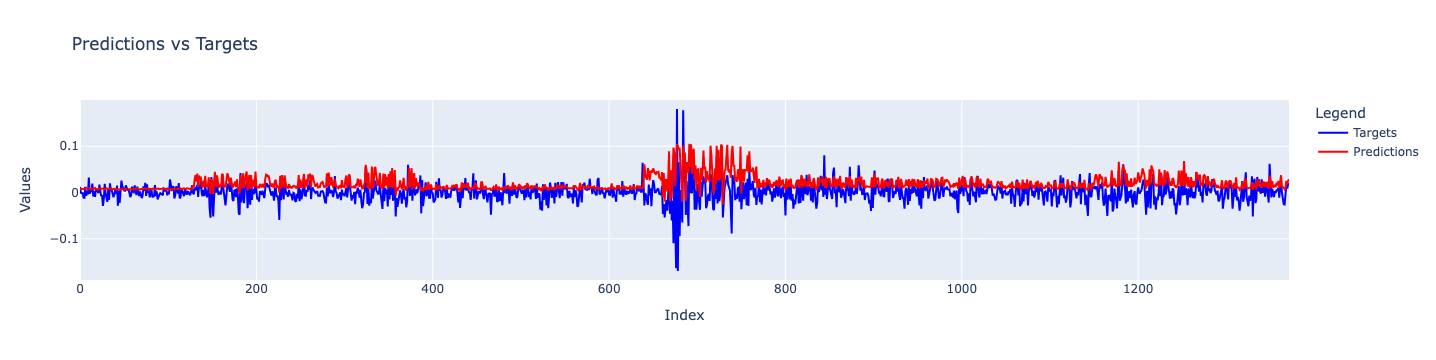

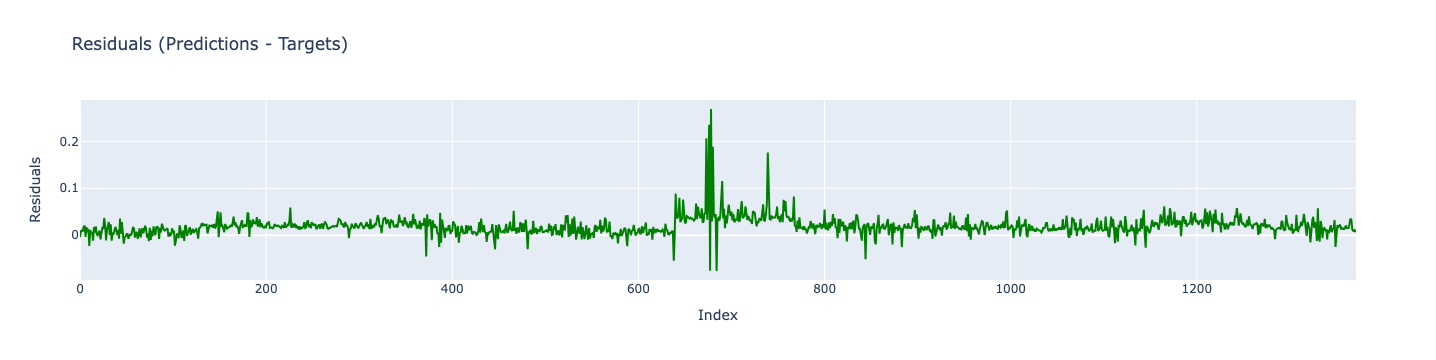

In [80]:
import plotly.graph_objects as go

def visualize_predictions_vs_target(predictions, targets):
    # Calculate residuals (difference between predictions and targets)
    residuals = predictions - targets

    # Create x-axis (index for plotting)
    x = np.arange(len(predictions))

    # Create line plot for predictions and targets
    fig = go.Figure()

    # Plot targets
    fig.add_trace(go.Scatter(x=x, y=targets, mode='lines', name='Targets', line=dict(color='blue')))
    
    # Plot predictions
    fig.add_trace(go.Scatter(x=x, y=predictions, mode='lines', name='Predictions', line=dict(color='red')))

    # Add title and labels
    fig.update_layout(
        title='Predictions vs Targets',
        xaxis_title='Index',
        yaxis_title='Values',
        legend_title='Legend',
        height=600
    )

    # Show plot
    fig.show()

    # Residuals plot (Difference between predictions and targets)
    fig_residuals = go.Figure()

    # Plot residuals
    fig_residuals.add_trace(go.Scatter(x=x, y=residuals, mode='lines', name='Residuals', line=dict(color='green')))

    # Add title and labels for residuals plot
    fig_residuals.update_layout(
        title='Residuals (Predictions - Targets)',
        xaxis_title='Index',
        yaxis_title='Residuals',
        height=600
    )

    # Show residuals plot
    fig_residuals.show()

visualize_predictions_vs_target(deFuzzify(pred, cls.y_cluster_stats[pred_col]), crisp_t_y)


In [37]:
y.shape

(4138, 8)

In [33]:
all_preds.shape

(4138, 8)

In [34]:
all_targets.shape

(4138, 8)

In [43]:
cls.y_cluster_stats['y_log_return_0']

{0: {'mean': np.float64(-0.23928210301371133),
  'std': np.float64(0.05194219801211237)},
 1: {'mean': np.float64(-0.15253550264852994),
  'std': np.float64(0.010413746511490407)},
 2: {'mean': np.float64(-0.10600404812715959),
  'std': np.float64(0.011546869280038686)},
 3: {'mean': np.float64(-0.0519643569928573),
  'std': np.float64(0.014571049995484054)},
 4: {'mean': np.float64(-0.010892969914091829),
  'std': np.float64(0.00970862276492395)},
 5: {'mean': np.float64(0.015303584064657098),
  'std': np.float64(0.009682180479312305)},
 6: {'mean': np.float64(0.05298666916599276),
  'std': np.float64(0.010041857574314186)},
 7: {'mean': np.float64(0.1345724956975827),
  'std': np.float64(0.08643161529008503)}}

In [44]:
[i['mean'] for i in cls.y_cluster_stats['y_log_return_0'].values()]

[np.float64(-0.23928210301371133),
 np.float64(-0.15253550264852994),
 np.float64(-0.10600404812715959),
 np.float64(-0.0519643569928573),
 np.float64(-0.010892969914091829),
 np.float64(0.015303584064657098),
 np.float64(0.05298666916599276),
 np.float64(0.1345724956975827)]

In [50]:
np.squeeze((all_preds * np.tile([i['mean'] for i in cls.y_cluster_stats['y_log_return_0'].values()],(all_preds.shape[0],1))).sum(axis = 1, keepdims= True))

array([0.00957996, 0.00918855, 0.0087886 , ..., 0.00832616, 0.00966396,
       0.00961016])

In [52]:
cls.y_cluster_stats['y_log_return_0']

{0: {'mean': np.float64(-0.23928210301371133),
  'std': np.float64(0.05194219801211237)},
 1: {'mean': np.float64(-0.15253550264852994),
  'std': np.float64(0.010413746511490407)},
 2: {'mean': np.float64(-0.10600404812715959),
  'std': np.float64(0.011546869280038686)},
 3: {'mean': np.float64(-0.0519643569928573),
  'std': np.float64(0.014571049995484054)},
 4: {'mean': np.float64(-0.010892969914091829),
  'std': np.float64(0.00970862276492395)},
 5: {'mean': np.float64(0.015303584064657098),
  'std': np.float64(0.009682180479312305)},
 6: {'mean': np.float64(0.05298666916599276),
  'std': np.float64(0.010041857574314186)},
 7: {'mean': np.float64(0.1345724956975827),
  'std': np.float64(0.08643161529008503)}}

In [12]:
def deFuzzify(pred: np.array, y_cluster_info: dict) -> np.array:
    """
    defuzzification uising weighted average technique
    transform fuzzy memberships -> log returns
    """
    centers = [dic['mean'] for dic in y_cluster_info.values()]
    stds = [dic['std'] for dic in y_cluster_info.values()]

    centers = np.tile(centers, (pred.shape[0], 1))
    pred = np.nan_to_num(pred, nan=0, posinf=0, neginf=0)

    denominator = pred.sum(axis=1, keepdims=True)
    numerator = (pred * centers).sum(axis = 1, keepdims=True)
    result = numerator / denominator
    result = np.squeeze(result)

    return result
    

In [59]:
deFuzzify(all_preds, cls.y_cluster_stats['y_log_return_0']).shape

(4138,)

In [75]:
from sklearn.metrics import r2_score

r2_score(train_X['Close'].iloc[13:], train_X['Close'].shift(13).iloc[13:])

0.935833218015573

In [67]:
train

NameError: name 'train' is not defined

In [70]:
train_X['Close']

Date
1999-07-06    25.664207
1999-07-07    25.695587
1999-07-08    25.774012
1999-07-09    25.993652
1999-07-12    25.601460
                ...    
2015-12-07    27.070307
2015-12-08    26.586359
2015-12-09    26.047758
2015-12-10    26.086788
2015-12-11    25.040825
Name: Close, Length: 4138, dtype: float64

In [72]:
train_X['Close'].shift(1)

Date
1999-07-06          NaN
1999-07-07    25.664207
1999-07-08    25.695587
1999-07-09    25.774012
1999-07-12    25.993652
                ...    
2015-12-07    27.569885
2015-12-08    27.070307
2015-12-09    26.586359
2015-12-10    26.047758
2015-12-11    26.086788
Name: Close, Length: 4138, dtype: float64